In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/All/'
class_names = ['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']

NUM_EPOCH_PER_TRAIN = 30

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 7

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.8, 0.2, 0.0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=10, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))

2022-10-16 15:34:21.031875: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print('Tenserflow version: ' +  str(tf.__version__))

2.9.1


In [3]:
def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1                
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            selectedFile = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = RATIO):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

In [21]:
#---------------MODEL1-----------------------------------------#

In [22]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name

In [23]:
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)#

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmpdj4ukcts/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmpdj4ukcts/train/Ae-albopictus/ = 7095.
No. of files in "/tmp/tmpdj4ukcts/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmpdj4ukcts/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmpdj4ukcts/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmpdj4ukcts/val/Ae-albopictus/ = 1771.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmpdj4ukcts/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmpdj4ukcts/train/An-tessellatus/ = 5797.
No. of files in "/tmp/tmpdj4ukcts/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmpdj4ukcts/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmpdj4ukcts/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmpdj4ukcts/val/An-tessellatus/ = 1408.
Found Ae-aegypti
No. of file

((24681, 6010, 0), (16454, 4005, 0))

In [24]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)

Found 24681 files belonging to 7 classes.


2022-10-15 19:17:18.360406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 19:17:19.667944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 6010 files belonging to 7 classes.
Found 24681 files belonging to 7 classes.
Found 6010 files belonging to 7 classes.


In [25]:
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)
class_names = train_ds.class_names
print(class_names)

['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']


In [26]:
earlyModelPath = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPath = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPath = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

In [27]:
model = keras.models.load_model(earlyModelPath)

In [ ]:
# model = buildEarlyModel()
# model.summary()

In [ ]:
# keras.utils.plot_model(model, "my_model_with_shape_info.png", show_shapes=True)

In [28]:
#model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)

In [29]:
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
maxAcc = np.max(fitHistory.history['val_accuracy'])

Start fitting from 2022/10/15-19:23:09

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-10-15 19:23:21.421308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1290 of 3086
2022-10-15 19:23:31.420703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2647 of 3086
2022-10-15 19:23:34.292636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-15 19:23:36.180149: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-15 19:23:39.537390: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3086/3086 [==============================] - 277s 80ms/step - loss: 0.3194 - accuracy: 0.8921 - val_loss: 0.2195 - val_accuracy: 0.9228 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3086/3086 [==============================] - 241s 78ms/step - loss: 0.1862 - accuracy: 0.9353 - val_loss: 0.3541 - val_accuracy: 0.8800 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3086/3086 [==============================] - 236s 76ms/step - loss: 0.1376 - accuracy: 0.9520 - val_loss: 0.2228 - val_accuracy: 0.9238 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3086/3086 [==============================] - 229s 74ms/step - loss: 0.0984 - accuracy: 0.9654 - val_loss: 0.2470 - val_accuracy: 0.9250 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
3086/3086 [=========

Maximum test accuracy is at 96.91 %.


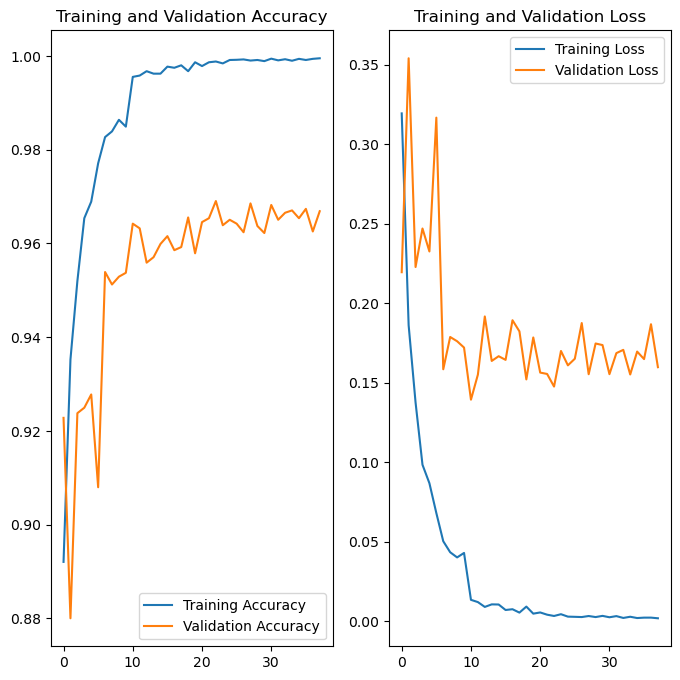

In [30]:
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [31]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)

752/752 [==============================] - 17s 21ms/step
Confusion Matrix
[[993  11   0   0   0   2   0]
 [  6 879   0   0   0   0   0]
 [  0   0 783  12   2   6   0]
 [  0   0   8 694   0   2   0]
 [  1   0   7   3 830  31  57]
 [  0   0  13   9   1 758   0]
 [  0   4   0   0  11   0 887]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.99      0.99      1006
      Ae-albopictus       0.98      0.99      0.99       885
          Ae-vexans       0.97      0.98      0.97       803
     An-tessellatus       0.97      0.99      0.98       704
Cx-quinquefasciatus       0.98      0.89      0.94       929
         Cx-vishnui       0.95      0.97      0.96       781
               Misc       0.94      0.98      0.96       902

           accuracy                           0.97      6010
          macro avg       0.97      0.97      0.97      6010
       weighted avg       0.97      0.97      0.97      6010

Model is s

In [32]:
model = keras.models.load_model(middleModelPath)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)

Start fitting from 2022/10/15-21:52:03

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3086/3086 [==============================] - 270s 87ms/step - loss: 0.1730 - accuracy: 0.9447 - val_loss: 0.2443 - val_accuracy: 0.9243 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3086/3086 [==============================] - 265s 86ms/step - loss: 0.0874 - accuracy: 0.9697 - val_loss: 0.1938 - val_accuracy: 0.9384 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3086/3086 [==============================] - 262s 85ms/step - loss: 0.0568 - accuracy: 0.9815 - val_loss: 0.0982 - val_accuracy: 0.9707 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3086/3086 [==============================] - 261s 85ms/step - loss: 0.0413 - accuracy: 0.9862 - val_loss: 0.0826 - val_accuracy: 0.976

Maximum test accuracy is at 98.49 %.


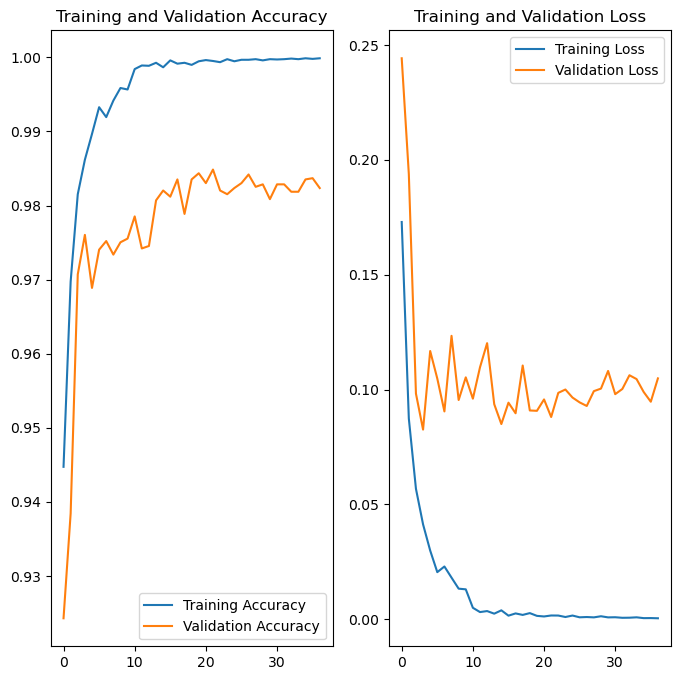

In [33]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [34]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)

752/752 [==============================] - 18s 24ms/step
Confusion Matrix
[[999   6   0   0   0   1   0]
 [  3 882   0   0   0   0   0]
 [  3   1 790   5   1   3   0]
 [  0   0   0 704   0   0   0]
 [  0   0   0   1 878  17  33]
 [  0   0   7   4   3 766   1]
 [  0   0   0   0   2   0 900]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.99      0.99      1006
      Ae-albopictus       0.99      1.00      0.99       885
          Ae-vexans       0.99      0.98      0.99       803
     An-tessellatus       0.99      1.00      0.99       704
Cx-quinquefasciatus       0.99      0.95      0.97       929
         Cx-vishnui       0.97      0.98      0.98       781
               Misc       0.96      1.00      0.98       902

           accuracy                           0.98      6010
          macro avg       0.98      0.99      0.98      6010
       weighted avg       0.99      0.98      0.98      6010

Model is s

In [35]:
model = keras.models.load_model(lateModelPath)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)

Start fitting from 2022/10/16-00:33:54

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3086/3086 [==============================] - 304s 98ms/step - loss: 0.2647 - accuracy: 0.9147 - val_loss: 0.2251 - val_accuracy: 0.9265 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3086/3086 [==============================] - 293s 95ms/step - loss: 0.1654 - accuracy: 0.9452 - val_loss: 0.2273 - val_accuracy: 0.9270 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3086/3086 [==============================] - 295s 96ms/step - loss: 0.1112 - accuracy: 0.9629 - val_loss: 0.2728 - val_accuracy: 0.9150 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3086/3086 [==============================] - 292s 95ms/step - loss: 0.0743 - accuracy: 0.9745 - val_loss: 0.2559 - val_accuracy: 0.923

Maximum test accuracy is at 95.16 %.


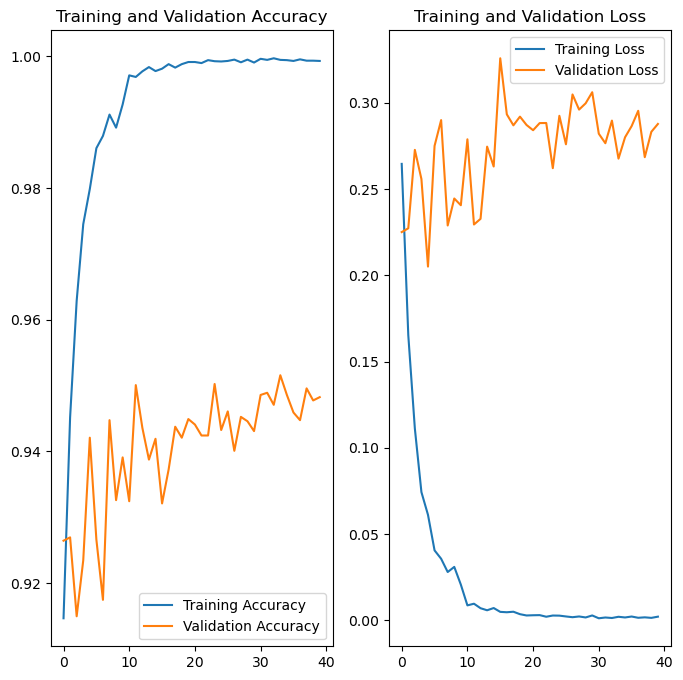

In [36]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [37]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)

752/752 [==============================] - 21s 27ms/step
Confusion Matrix
[[987  17   2   0   0   0   0]
 [  1 884   0   0   0   0   0]
 [  1  20 728   0   3  51   0]
 [  0   0   2 700   0   2   0]
 [  0   0   2   0 838  35  54]
 [  3   3  96   2   5 672   0]
 [  0   1   0   0   9   2 890]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.98      0.99      1006
      Ae-albopictus       0.96      1.00      0.98       885
          Ae-vexans       0.88      0.91      0.89       803
     An-tessellatus       1.00      0.99      1.00       704
Cx-quinquefasciatus       0.98      0.90      0.94       929
         Cx-vishnui       0.88      0.86      0.87       781
               Misc       0.94      0.99      0.96       902

           accuracy                           0.95      6010
          macro avg       0.95      0.95      0.95      6010
       weighted avg       0.95      0.95      0.95      6010

Model is s

In [38]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)

Found 16454 files belonging to 7 classes.
Found 4005 files belonging to 7 classes.
Found 16454 files belonging to 7 classes.
Found 4005 files belonging to 7 classes.
Found 16454 files belonging to 7 classes.
Found 4005 files belonging to 7 classes.


In [39]:
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)

In [40]:
model = keras.models.load_model(earlyModelPath)
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

501/501 [==============================] - 11s 22ms/step


In [41]:
model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)


501/501 [==============================] - 13s 25ms/step


In [42]:
model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

501/501 [==============================] - 14s 28ms/step


In [43]:
Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))

In [44]:
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)

In [45]:
ensemble = trainEnsemble(Yh_train, Y_train)

Epoch 1/20
1029/1029 [==============================] - 5s 4ms/step - loss: 0.3878 - accuracy: 0.9727
Epoch 2/20
1029/1029 [==============================] - 4s 4ms/step - loss: 0.1078 - accuracy: 0.9994
Epoch 3/20
1029/1029 [==============================] - 4s 4ms/step - loss: 0.0464 - accuracy: 0.9998
Epoch 4/20
1029/1029 [==============================] - 4s 4ms/step - loss: 0.0225 - accuracy: 0.9999
Epoch 5/20
1029/1029 [==============================] - 4s 4ms/step - loss: 0.0120 - accuracy: 0.9999
Epoch 6/20
1029/1029 [==============================] - 4s 4ms/step - loss: 0.0068 - accuracy: 1.0000
Epoch 7/20
1029/1029 [==============================] - 4s 3ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 8/20
1029/1029 [==============================] - 4s 4ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 9/20
1029/1029 [==============================] - 3s 3ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 10/20
1029/1029 [==============================] - 3s 3ms/step - loss: 8.892

In [46]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1

126/126 [==============================] - 1s 3ms/step - loss: 0.0125 - accuracy: 0.9973


126/126 [==============================] - 0s 2ms/step


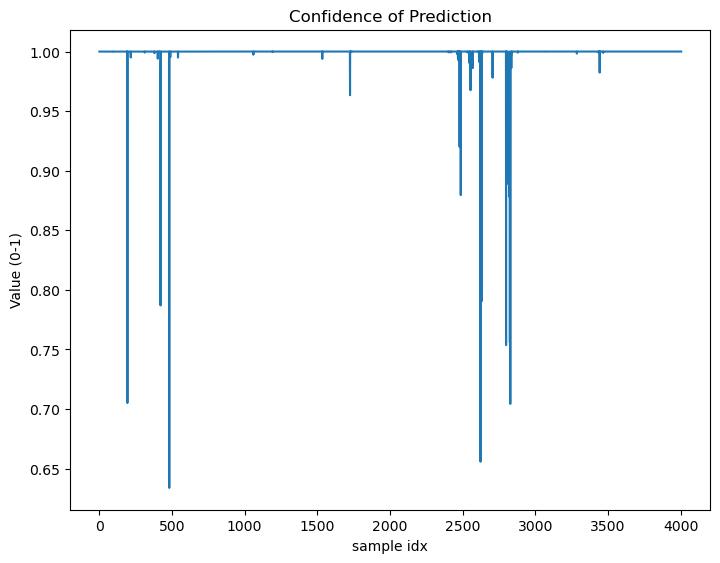

In [47]:
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [48]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
gc.collect()
dir()
tf.keras.backend.clear_session()


In [ ]:
#---------------MODEL2-----------------------------------------#

In [21]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

In [22]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmp893n_nbh/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmp893n_nbh/train/Ae-albopictus/ = 7172.
No. of files in "/tmp/tmp893n_nbh/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmp893n_nbh/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmp893n_nbh/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmp893n_nbh/val/Ae-albopictus/ = 1694.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmp893n_nbh/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmp893n_nbh/train/An-tessellatus/ = 5786.
No. of files in "/tmp/tmp893n_nbh/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmp893n_nbh/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmp893n_nbh/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmp893n_nbh/val/An-tessellatus/ = 1419.
Found Ae-aegypti
No. of file

((24744, 5950, 0), (16494, 3965, 0))

In [23]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24744 files belonging to 7 classes.


2022-10-16 06:50:20.178032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 06:50:21.392898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 5950 files belonging to 7 classes.
Found 24744 files belonging to 7 classes.
Found 5950 files belonging to 7 classes.


In [24]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/16-06:51:41

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-16 06:51:53.811342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1353 of 3093
2022-10-16 06:52:03.809274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2720 of 3093
2022-10-16 06:52:06.292539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-16 06:52:08.214578: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-16 06:52:11.368576: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3093/3093 [==============================] - 280s 81ms/step - loss: 0.3297 - accuracy: 0.8894 - val_loss: 0.1820 - val_accuracy: 0.9361 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3093/3093 [==============================] - 247s 80ms/step - loss: 0.2064 - accuracy: 0.9275 - val_loss: 0.2649 - val_accuracy: 0.9013 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3093/3093 [==============================] - 242s 78ms/step - loss: 0.1432 - accuracy: 0.9492 - val_loss: 0.2219 - val_accuracy: 0.9277 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3093/3093 [==============================] - 240s 78ms/step - loss: 0.1133 - accuracy: 0.9615 - val_loss: 0.1810 - val_accuracy: 0.9365 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3093/3093 [=========

Maximum test accuracy is at 97.13 %.


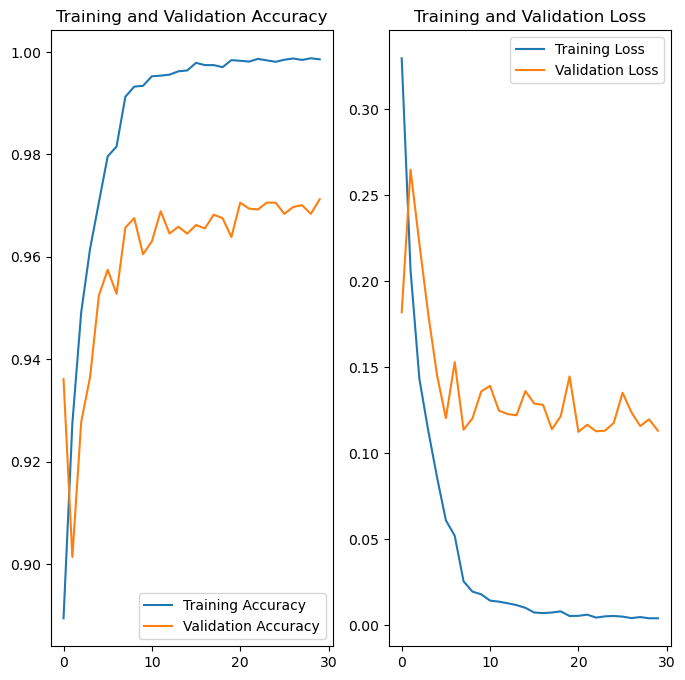

In [25]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [26]:
class_names = ['Aedes aegypti', 'Aedes albopictus', 'Aedes vexans', 'An tessellatus', 'Culex quinquefasciatus', 'Culex vishnui', 'Others']
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

744/744 [==============================] - 19s 24ms/step
Confusion Matrix
[[959   8   0   0   0   1   0]
 [ 25 819   0   2   0   1   0]
 [  1   0 777   4   0   8   2]
 [  0   0   1 706   0   2   0]
 [  0   0   1   0 846  17  49]
 [  0   1   0   1  11 778   1]
 [  0   4   3   1  15  12 894]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.97      0.99      0.98       968
      Aedes albopictus       0.98      0.97      0.98       847
          Aedes vexans       0.99      0.98      0.99       792
        An tessellatus       0.99      1.00      0.99       709
Culex quinquefasciatus       0.97      0.93      0.95       913
         Culex vishnui       0.95      0.98      0.97       792
                Others       0.95      0.96      0.95       929

              accuracy                           0.97      5950
             macro avg       0.97      0.97      0.97      5950
          weighted avg       0.97      0.9

In [27]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/16-08:50:52

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3093/3093 [==============================] - 280s 90ms/step - loss: 0.1709 - accuracy: 0.9429 - val_loss: 0.0710 - val_accuracy: 0.9768 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3093/3093 [==============================] - 277s 90ms/step - loss: 0.0918 - accuracy: 0.9704 - val_loss: 0.1596 - val_accuracy: 0.9501 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3093/3093 [==============================] - 276s 89ms/step - loss: 0.0577 - accuracy: 0.9807 - val_loss: 0.0878 - val_accuracy: 0.9724 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3093/3093 [==============================] - 276s 89ms/step - loss: 0.0316 - accuracy: 0.9894 - val_loss: 0.0701 - val_accuracy: 0.975

Maximum test accuracy is at 98.79 %.


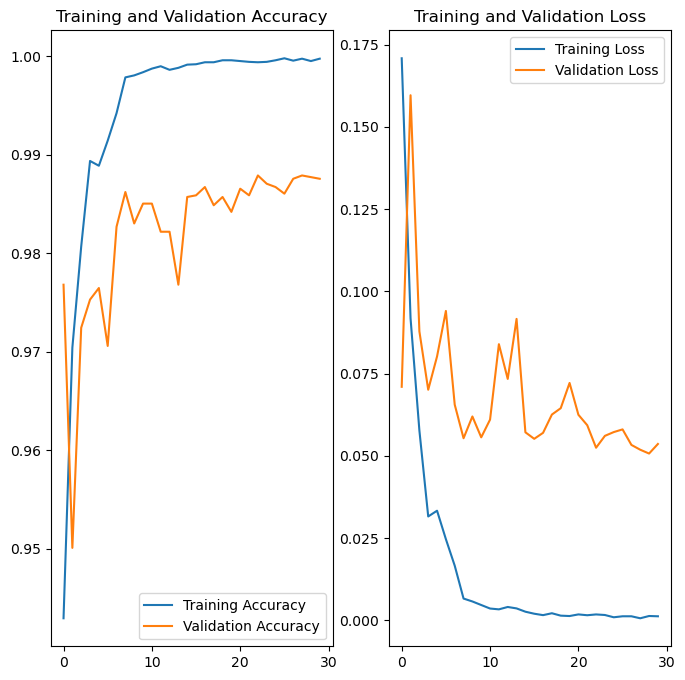

In [28]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [29]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

744/744 [==============================] - 18s 23ms/step
Confusion Matrix
[[963   5   0   0   0   0   0]
 [ 15 831   0   1   0   0   0]
 [  0   0 783   5   2   2   0]
 [  0   0   0 709   0   0   0]
 [  1   0   0   0 885  10  17]
 [  0   0   1   0   0 791   0]
 [  0   5   1   0   6   3 914]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.98      0.99      0.99       968
      Aedes albopictus       0.99      0.98      0.98       847
          Aedes vexans       1.00      0.99      0.99       792
        An tessellatus       0.99      1.00      1.00       709
Culex quinquefasciatus       0.99      0.97      0.98       913
         Culex vishnui       0.98      1.00      0.99       792
                Others       0.98      0.98      0.98       929

              accuracy                           0.99      5950
             macro avg       0.99      0.99      0.99      5950
          weighted avg       0.99      0.9

In [30]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/16-11:06:32

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3093/3093 [==============================] - 307s 99ms/step - loss: 0.2792 - accuracy: 0.9090 - val_loss: 0.3564 - val_accuracy: 0.8803 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3093/3093 [==============================] - 303s 98ms/step - loss: 0.1748 - accuracy: 0.9415 - val_loss: 0.2782 - val_accuracy: 0.9160 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3093/3093 [==============================] - 304s 98ms/step - loss: 0.1177 - accuracy: 0.9608 - val_loss: 0.2304 - val_accuracy: 0.9220 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3093/3093 [==============================] - 304s 98ms/step - loss: 0.0927 - accuracy: 0.9689 - val_loss: 0.1401 - val_accuracy: 0.954

Maximum test accuracy is at 96.54 %.


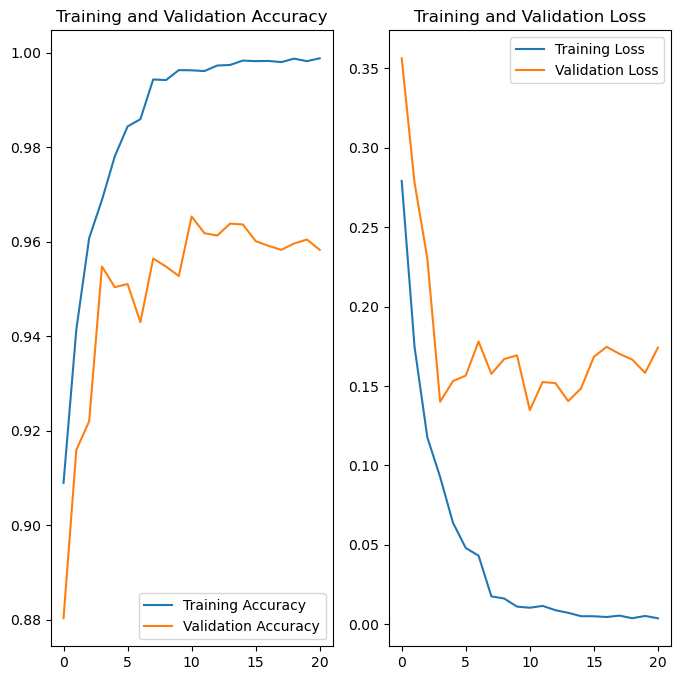

In [31]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [32]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

744/744 [==============================] - 84s 112ms/step
Confusion Matrix
[[962   3   3   0   0   0   0]
 [ 29 817   0   1   0   0   0]
 [ 30  19 707   3   1  32   0]
 [  0   0   2 706   0   1   0]
 [  4   0   1   0 880   4  24]
 [  2   1   9   0   9 770   1]
 [  0   0   0   0  26   1 902]]


Classification Report
                        precision    recall  f1-score   support

         Aedes aegypti       0.94      0.99      0.96       968
      Aedes albopictus       0.97      0.96      0.97       847
          Aedes vexans       0.98      0.89      0.93       792
        An tessellatus       0.99      1.00      1.00       709
Culex quinquefasciatus       0.96      0.96      0.96       913
         Culex vishnui       0.95      0.97      0.96       792
                Others       0.97      0.97      0.97       929

              accuracy                           0.97      5950
             macro avg       0.97      0.96      0.97      5950
          weighted avg       0.97      0.

In [34]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
gc.collect()
dir()
tf.keras.backend.clear_session()

In [35]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16494 files belonging to 7 classes.
Found 3965 files belonging to 7 classes.
Found 16494 files belonging to 7 classes.
Found 3965 files belonging to 7 classes.
Found 16494 files belonging to 7 classes.
Found 3965 files belonging to 7 classes.


In [36]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

496/496 [==============================] - 14s 28ms/step


In [37]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------


Epoch 1/20
1031/1031 [==============================] - 5s 4ms/step - loss: 0.2255 - accuracy: 0.9388
Epoch 2/20
1031/1031 [==============================] - 5s 4ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 3/20
1031/1031 [==============================] - 5s 5ms/step - loss: 6.2153e-04 - accuracy: 1.0000
Epoch 4/20
1031/1031 [==============================] - 5s 5ms/step - loss: 2.6721e-04 - accuracy: 1.0000
Epoch 5/20
1031/1031 [==============================] - 5s 5ms/step - loss: 1.3419e-04 - accuracy: 1.0000
Epoch 6/20
1031/1031 [==============================] - 5s 5ms/step - loss: 7.3227e-05 - accuracy: 1.0000
Epoch 7/20
1031/1031 [==============================] - 5s 5ms/step - loss: 4.1061e-05 - accuracy: 1.0000
Epoch 8/20
1031/1031 [==============================] - 5s 5ms/step - loss: 2.3425e-05 - accuracy: 1.0000
Epoch 9/20
1031/1031 [==============================] - 5s 4ms/step - loss: 1.3513e-05 - accuracy: 1.0000
Epoch 10/20
1031/1031 [==============================]

124/124 [==============================] - 0s 2ms/step


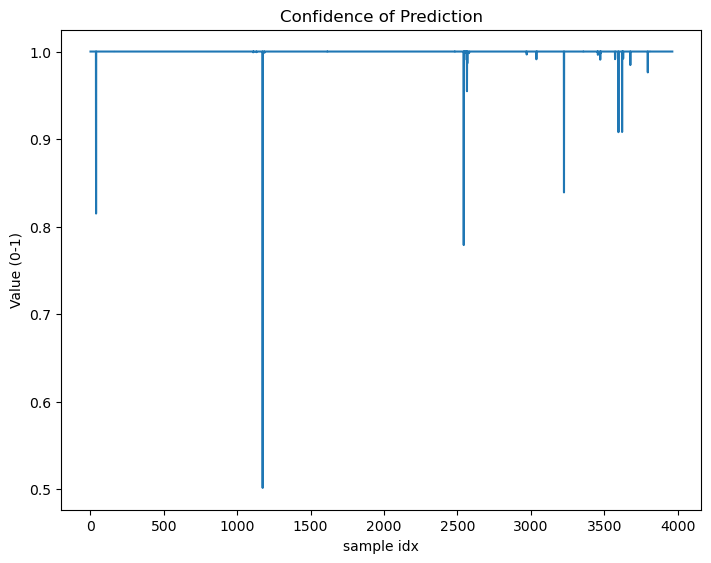

In [38]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [39]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

24611

In [21]:
#---------------MODEL3-----------------------------------------#

In [22]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

In [23]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----



Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmp3a4l3xt8/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmp3a4l3xt8/train/Ae-albopictus/ = 7183.
No. of files in "/tmp/tmp3a4l3xt8/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmp3a4l3xt8/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmp3a4l3xt8/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmp3a4l3xt8/val/Ae-albopictus/ = 1683.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmp3a4l3xt8/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmp3a4l3xt8/train/An-tessellatus/ = 5797.
No. of files in "/tmp/tmp3a4l3xt8/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmp3a4l3xt8/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmp3a4l3xt8/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmp3a4l3xt8/val/An-tessellatus/ = 1408.
Found Ae-aegypti
No. of file

((24709, 5982, 0), (16472, 3988, 0))

In [24]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24709 files belonging to 7 classes.


2022-10-16 15:36:29.425094: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 15:36:30.782436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 5982 files belonging to 7 classes.
Found 24709 files belonging to 7 classes.
Found 5982 files belonging to 7 classes.


In [25]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/16-15:36:55

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-16 15:37:07.164075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1348 of 3089
2022-10-16 15:37:17.153998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2708 of 3089
2022-10-16 15:37:19.780690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-16 15:37:21.925045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-16 15:37:25.512324: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3089/3089 [==============================] - 278s 80ms/step - loss: 0.3304 - accuracy: 0.8872 - val_loss: 0.2184 - val_accuracy: 0.9224 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 238s 77ms/step - loss: 0.1927 - accuracy: 0.9346 - val_loss: 0.1700 - val_accuracy: 0.9443 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 234s 76ms/step - loss: 0.1466 - accuracy: 0.9489 - val_loss: 0.2367 - val_accuracy: 0.9236 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 235s 76ms/step - loss: 0.1021 - accuracy: 0.9633 - val_loss: 0.1226 - val_accuracy: 0.9594 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3089/3089 [=========

Maximum test accuracy is at 97.53 %.


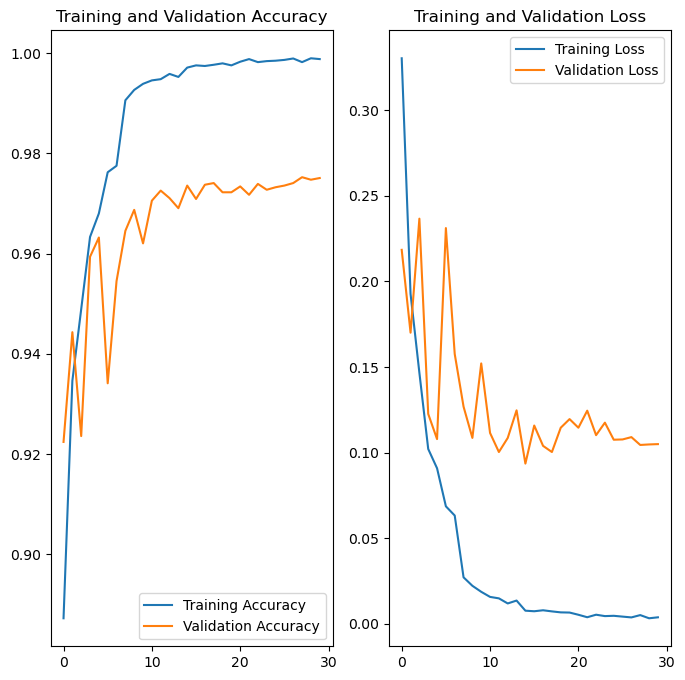

In [26]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [27]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

748/748 [==============================] - 15s 19ms/step
Confusion Matrix
[[966  15   4   1   5  14   1]
 [  8 833   0   0   0   0   0]
 [  2   0 765   0   0   3   0]
 [  0   0   1 702   0   1   0]
 [  0   0   0   0 883  27  30]
 [  1   0  14   1   0 797   1]
 [  0   0   0   0  11   9 887]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.96      0.97      1006
      Ae-albopictus       0.98      0.99      0.99       841
          Ae-vexans       0.98      0.99      0.98       770
     An-tessellatus       1.00      1.00      1.00       704
Cx-quinquefasciatus       0.98      0.94      0.96       940
         Cx-vishnui       0.94      0.98      0.96       814
               Misc       0.97      0.98      0.97       907

           accuracy                           0.98      5982
          macro avg       0.98      0.98      0.98      5982
       weighted avg       0.98      0.98      0.98      5982

Model is s

In [28]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/16-17:29:58

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3089/3089 [==============================] - 267s 86ms/step - loss: 0.1690 - accuracy: 0.9456 - val_loss: 0.0987 - val_accuracy: 0.9707 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 258s 84ms/step - loss: 0.0833 - accuracy: 0.9722 - val_loss: 0.0966 - val_accuracy: 0.9711 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 263s 85ms/step - loss: 0.0663 - accuracy: 0.9776 - val_loss: 0.0991 - val_accuracy: 0.9719 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 260s 84ms/step - loss: 0.0423 - accuracy: 0.9860 - val_loss: 0.1052 - val_accuracy: 0.967

Maximum test accuracy is at 99.08 %.


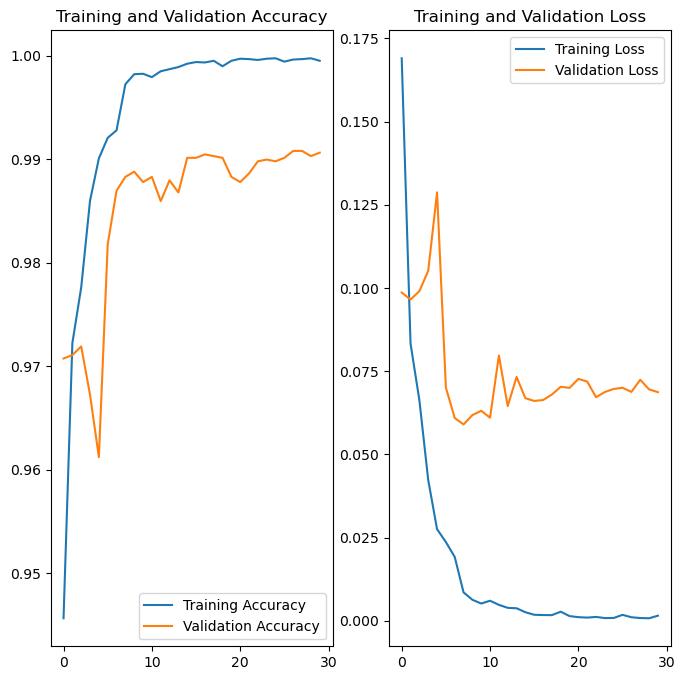

In [29]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [30]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

748/748 [==============================] - 17s 22ms/step
Confusion Matrix
[[1000    3    0    0    0    3    0]
 [   0  841    0    0    0    0    0]
 [   0    0  770    0    0    0    0]
 [   0    0    0  704    0    0    0]
 [   0    0    0    0  904   34    2]
 [   0    0    5    1    1  807    0]
 [   0    1    0    0    5    1  900]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       1.00      0.99      1.00      1006
      Ae-albopictus       1.00      1.00      1.00       841
          Ae-vexans       0.99      1.00      1.00       770
     An-tessellatus       1.00      1.00      1.00       704
Cx-quinquefasciatus       0.99      0.96      0.98       940
         Cx-vishnui       0.96      0.99      0.97       814
               Misc       1.00      0.99      1.00       907

           accuracy                           0.99      5982
          macro avg       0.99      0.99      0.99      5982
       weighted avg    

In [31]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/16-19:41:05

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3089/3089 [==============================] - 302s 97ms/step - loss: 0.2719 - accuracy: 0.9115 - val_loss: 0.3075 - val_accuracy: 0.8995 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 299s 97ms/step - loss: 0.1666 - accuracy: 0.9451 - val_loss: 0.1608 - val_accuracy: 0.9445 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 297s 96ms/step - loss: 0.1089 - accuracy: 0.9640 - val_loss: 0.1804 - val_accuracy: 0.9465 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 299s 97ms/step - loss: 0.0786 - accuracy: 0.9737 - val_loss: 0.1544 - val_accuracy: 0.947

Maximum test accuracy is at 96.52 %.


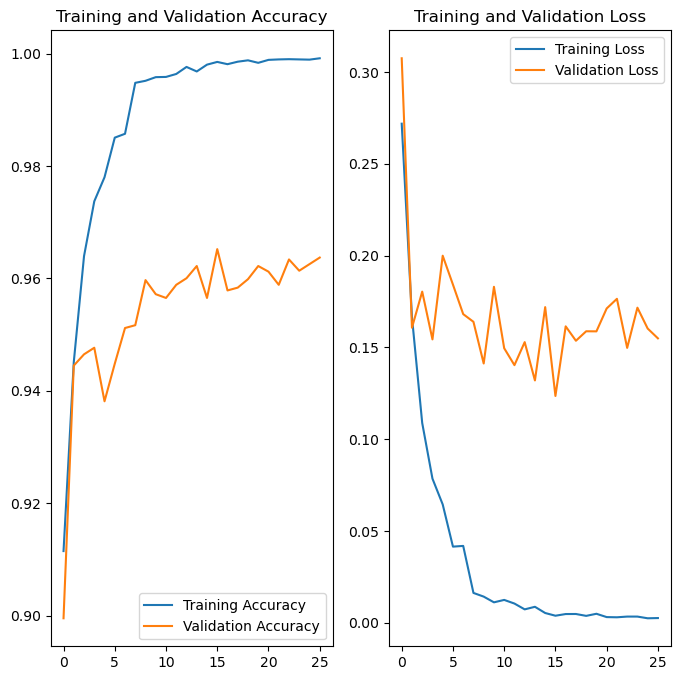

In [32]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [33]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

748/748 [==============================] - 20s 27ms/step
Confusion Matrix
[[927  70   0   9   0   0   0]
 [ 28 811   0   0   0   2   0]
 [ 11   0 756   0   0   3   0]
 [  6   0   3 685   0  10   0]
 [  2   0   0   1 913   6  18]
 [  4   0  23   7   3 777   0]
 [  0   1   0   0   1   0 905]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.95      0.92      0.93      1006
      Ae-albopictus       0.92      0.96      0.94       841
          Ae-vexans       0.97      0.98      0.97       770
     An-tessellatus       0.98      0.97      0.97       704
Cx-quinquefasciatus       1.00      0.97      0.98       940
         Cx-vishnui       0.97      0.95      0.96       814
               Misc       0.98      1.00      0.99       907

           accuracy                           0.97      5982
          macro avg       0.97      0.97      0.97      5982
       weighted avg       0.97      0.97      0.97      5982

Model is s

In [34]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16472 files belonging to 7 classes.
Found 3988 files belonging to 7 classes.
Found 16472 files belonging to 7 classes.
Found 3988 files belonging to 7 classes.
Found 16472 files belonging to 7 classes.
Found 3988 files belonging to 7 classes.


In [35]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

499/499 [==============================] - 15s 29ms/step


In [36]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------


Epoch 1/20
1030/1030 [==============================] - 5s 4ms/step - loss: 0.2477 - accuracy: 0.9259
Epoch 2/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 3/20
1030/1030 [==============================] - 5s 5ms/step - loss: 7.3709e-04 - accuracy: 1.0000
Epoch 4/20
1030/1030 [==============================] - 5s 5ms/step - loss: 3.2490e-04 - accuracy: 1.0000
Epoch 5/20
1030/1030 [==============================] - 5s 5ms/step - loss: 1.6442e-04 - accuracy: 1.0000
Epoch 6/20
1030/1030 [==============================] - 5s 5ms/step - loss: 8.7760e-05 - accuracy: 1.0000
Epoch 7/20
1030/1030 [==============================] - 5s 5ms/step - loss: 5.0547e-05 - accuracy: 1.0000
Epoch 8/20
1030/1030 [==============================] - 5s 5ms/step - loss: 2.8128e-05 - accuracy: 1.0000
Epoch 9/20
1030/1030 [==============================] - 5s 5ms/step - loss: 1.6497e-05 - accuracy: 1.0000
Epoch 10/20
1030/1030 [==============================]

125/125 [==============================] - 0s 2ms/step


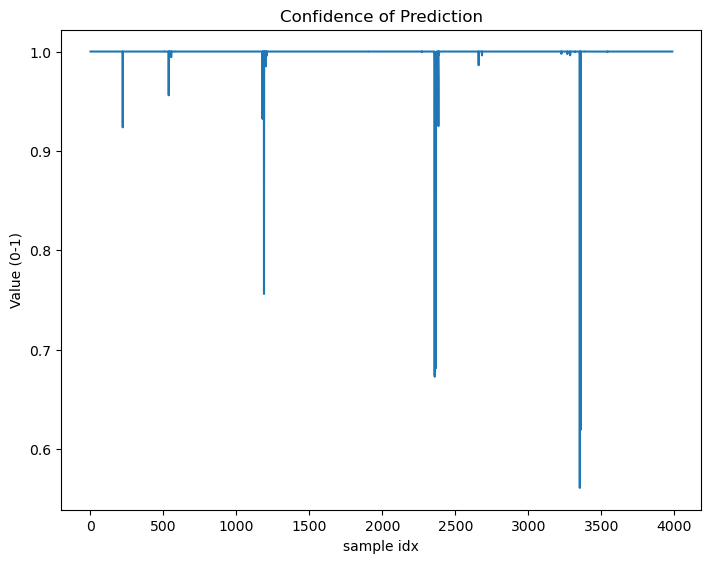

In [37]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [38]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

30281

In [ ]:
#---------------Run 4-----------------------------------------#

In [1]:

from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.lab.kernel.restart()</script>",raw=True)

In [2]:
restartkernel()

In [3]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/All/'
class_names = ['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']

NUM_EPOCH_PER_TRAIN = 30

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 7

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.8, 0.2, 0.0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=10, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))
#--------


def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1                
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            selectedFile = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = RATIO):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

2022-10-16 23:07:18.897253: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmp4c_l8pyj/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmp4c_l8pyj/train/Ae-albopictus/ = 7117.
No. of files in "/tmp/tmp4c_l8pyj/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmp4c_l8pyj/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmp4c_l8pyj/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmp4c_l8pyj/val/Ae-albopictus/ = 1749.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmp4c_l8pyj/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmp4c_l8pyj/train/An-tessellatus/ = 5786.
No. of files in "/tmp/tmp4c_l8pyj/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmp4c_l8pyj/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmp4c_l8pyj/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmp4c_l8pyj/val/An-tessellatus/ = 1419.
Found Ae-aegypti
No. of file

((24683, 6009, 0), (16453, 4006, 0))

In [5]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24683 files belonging to 7 classes.


2022-10-16 23:08:21.228127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 23:08:22.809858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 6009 files belonging to 7 classes.
Found 24683 files belonging to 7 classes.
Found 6009 files belonging to 7 classes.


In [6]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/16-23:08:51

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-16 23:09:03.234815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1119 of 3086
2022-10-16 23:09:13.222102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2368 of 3086
2022-10-16 23:09:18.115018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-16 23:09:20.032592: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-16 23:09:23.349921: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3086/3086 [==============================] - 280s 80ms/step - loss: 0.3399 - accuracy: 0.8858 - val_loss: 0.2568 - val_accuracy: 0.9140 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 238s 77ms/step - loss: 0.1984 - accuracy: 0.9312 - val_loss: 0.1881 - val_accuracy: 0.9409 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 238s 77ms/step - loss: 0.1491 - accuracy: 0.9466 - val_loss: 0.2122 - val_accuracy: 0.9339 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 239s 78ms/step - loss: 0.1215 - accuracy: 0.9574 - val_loss: 0.1486 - val_accuracy: 0.9501 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3086/3086 [=========

Maximum test accuracy is at 97.25 %.


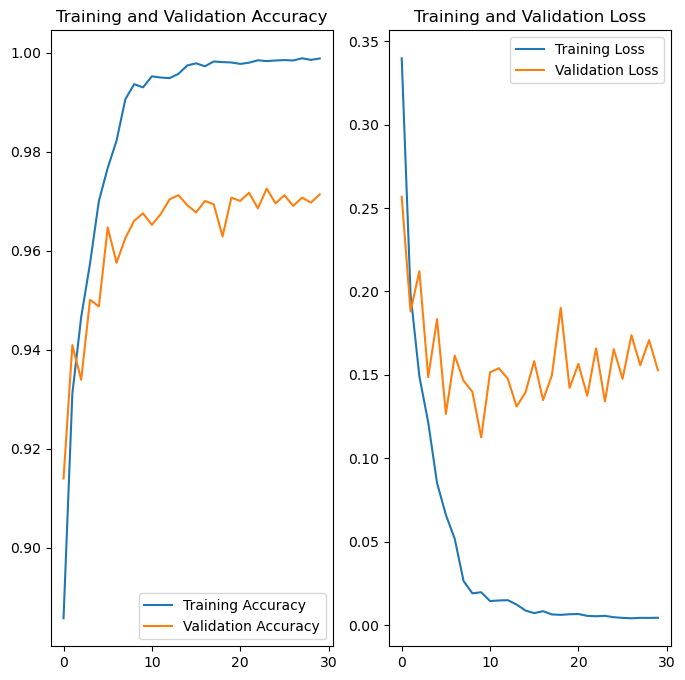

In [7]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [8]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

752/752 [==============================] - 18s 22ms/step
Confusion Matrix
[[978  27   2   1   1   2   1]
 [  6 868   0   0   0   0   0]
 [  2   0 792   0   0   3   0]
 [  0   0   1 704   0   4   0]
 [  0   0   1   2 843   5  84]
 [  0   0  13   2   2 790   1]
 [  3   5   0   0   4   0 862]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.97      0.98      1012
      Ae-albopictus       0.96      0.99      0.98       874
          Ae-vexans       0.98      0.99      0.99       797
     An-tessellatus       0.99      0.99      0.99       709
Cx-quinquefasciatus       0.99      0.90      0.94       935
         Cx-vishnui       0.98      0.98      0.98       808
               Misc       0.91      0.99      0.95       874

           accuracy                           0.97      6009
          macro avg       0.97      0.97      0.97      6009
       weighted avg       0.97      0.97      0.97      6009

Model is s

In [9]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-01:07:43

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3086/3086 [==============================] - 281s 91ms/step - loss: 0.1887 - accuracy: 0.9372 - val_loss: 0.1313 - val_accuracy: 0.9542 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 277s 90ms/step - loss: 0.0954 - accuracy: 0.9663 - val_loss: 0.0993 - val_accuracy: 0.9675 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 275s 89ms/step - loss: 0.0725 - accuracy: 0.9767 - val_loss: 0.1191 - val_accuracy: 0.9586 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 277s 90ms/step - loss: 0.0391 - accuracy: 0.9880 - val_loss: 0.0745 - val_accuracy: 0.973

Maximum test accuracy is at 99.0 %.


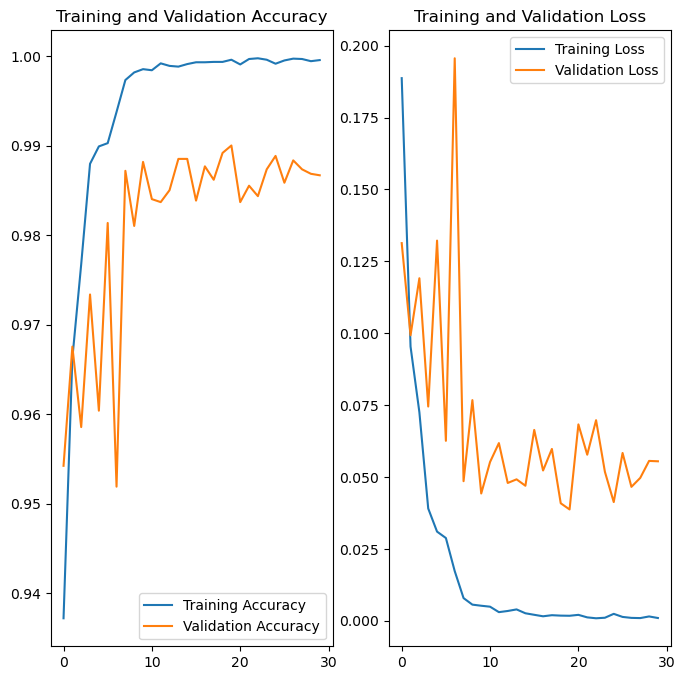

In [10]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [11]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

752/752 [==============================] - 20s 26ms/step
Confusion Matrix
[[1008    2    2    0    0    0    0]
 [  11  863    0    0    0    0    0]
 [   0    0  796    0    1    0    0]
 [   0    0    0  704    0    0    5]
 [   0    0    1    0  900    3   31]
 [   0    0    1    0    0  807    0]
 [   0    0    0    0    3    0  871]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      1.00      0.99      1012
      Ae-albopictus       1.00      0.99      0.99       874
          Ae-vexans       0.99      1.00      1.00       797
     An-tessellatus       1.00      0.99      1.00       709
Cx-quinquefasciatus       1.00      0.96      0.98       935
         Cx-vishnui       1.00      1.00      1.00       808
               Misc       0.96      1.00      0.98       874

           accuracy                           0.99      6009
          macro avg       0.99      0.99      0.99      6009
       weighted avg    

In [12]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-03:22:37

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3086/3086 [==============================] - 306s 99ms/step - loss: 0.2572 - accuracy: 0.9153 - val_loss: 0.3537 - val_accuracy: 0.9158 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 303s 98ms/step - loss: 0.1608 - accuracy: 0.9467 - val_loss: 0.3722 - val_accuracy: 0.9249 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 301s 98ms/step - loss: 0.1054 - accuracy: 0.9660 - val_loss: 0.2548 - val_accuracy: 0.9456 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 302s 98ms/step - loss: 0.0732 - accuracy: 0.9752 - val_loss: 0.3246 - val_accuracy: 0.936

Maximum test accuracy is at 94.71 %.


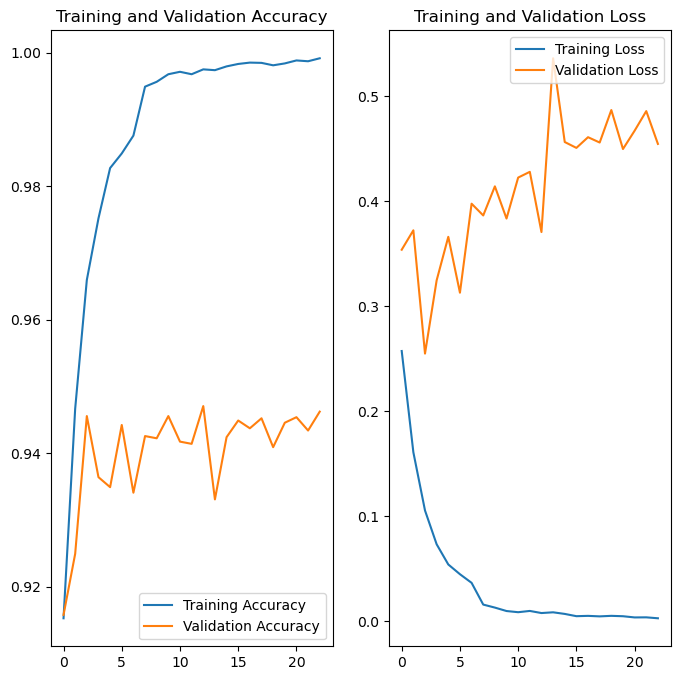

In [13]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [14]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

752/752 [==============================] - 20s 27ms/step
Confusion Matrix
[[1006    4    1    0    0    0    1]
 [   0  874    0    0    0    0    0]
 [   8   30  704    3    9   43    0]
 [   0    0    0  707    2    0    0]
 [   0    0    0    0  748   34  153]
 [   0    0   15    4    3  785    1]
 [   0    0    0    0    6    1  867]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.99      0.99      1012
      Ae-albopictus       0.96      1.00      0.98       874
          Ae-vexans       0.98      0.88      0.93       797
     An-tessellatus       0.99      1.00      0.99       709
Cx-quinquefasciatus       0.97      0.80      0.88       935
         Cx-vishnui       0.91      0.97      0.94       808
               Misc       0.85      0.99      0.91       874

           accuracy                           0.95      6009
          macro avg       0.95      0.95      0.95      6009
       weighted avg    

In [15]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16453 files belonging to 7 classes.
Found 4006 files belonging to 7 classes.
Found 16453 files belonging to 7 classes.
Found 4006 files belonging to 7 classes.
Found 16453 files belonging to 7 classes.
Found 4006 files belonging to 7 classes.


In [16]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

501/501 [==============================] - 14s 28ms/step


In [17]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
1029/1029 [==============================] - 5s 4ms/step - loss: 0.2493 - accuracy: 0.9258
Epoch 2/20
1029/1029 [==============================] - 5s 5ms/step - loss: 0.0028 - accuracy: 0.9999
Epoch 3/20
1029/1029 [==============================] - 5s 4ms/step - loss: 9.6850e-04 - accuracy: 0.9999
Epoch 4/20
1029/1029 [==============================] - 5s 4ms/step - loss: 4.7859e-04 - accuracy: 0.9999
Epoch 5/20
1029/1029 [==============================] - 5s 4ms/step - loss: 2.4464e-04 - accuracy: 0.9999
Epoch 6/20
1029/1029 [==============================] - 5s 4ms/step - loss: 1.2680e-04 - accuracy: 1.0000
Epoch 7/20
1029/1029 [==============================] - 5s 4ms/step - loss: 6.5828e-05 - accuracy: 1.0000
Epoch 8/20
1029/1029 [==============================] - 5s 5ms/step - loss: 3.6554e-05 - accuracy: 1.0000
Epoch 9/20
1029/1029 [==============================] - 5s 4ms/step - loss: 2.1268e-05 - accuracy: 1.0000
Epoch 10/20
1029/1029 [==============================]

126/126 [==============================] - 0s 2ms/step


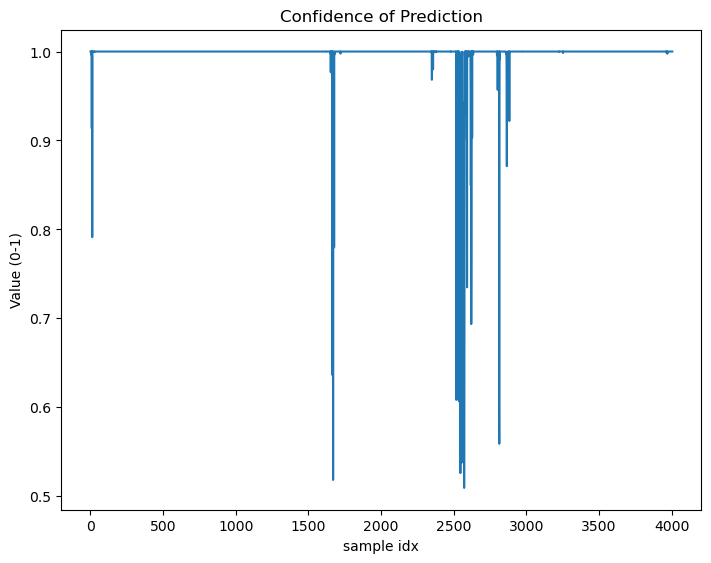

In [18]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)


In [19]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

23697

In [20]:
#---------------MODEL 5-----------------------------------------#

In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/All/'
class_names = ['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']

NUM_EPOCH_PER_TRAIN = 30

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 7

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.8, 0.2, 0.0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=10, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))
#--------


def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1                
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            selectedFile = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = RATIO):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

2022-10-17 06:43:55.464427: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmpw8ch7c38/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmpw8ch7c38/train/Ae-albopictus/ = 7150.
No. of files in "/tmp/tmpw8ch7c38/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmpw8ch7c38/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmpw8ch7c38/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmpw8ch7c38/val/Ae-albopictus/ = 1716.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmpw8ch7c38/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmpw8ch7c38/train/An-tessellatus/ = 5819.
No. of files in "/tmp/tmpw8ch7c38/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmpw8ch7c38/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmpw8ch7c38/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmpw8ch7c38/val/An-tessellatus/ = 1386.
Found Ae-aegypti
No. of file

((24694, 5999, 0), (16460, 3998, 0))

In [3]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24694 files belonging to 7 classes.


2022-10-17 06:44:54.769629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 06:44:56.089142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 5999 files belonging to 7 classes.
Found 24694 files belonging to 7 classes.
Found 5999 files belonging to 7 classes.


In [4]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-06:45:23

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-17 06:45:35.890368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1297 of 3087
2022-10-17 06:45:45.911367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2574 of 3087
2022-10-17 06:45:49.581987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-17 06:45:51.811728: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-17 06:45:55.591719: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3087/3087 [==============================] - 279s 79ms/step - loss: 0.3164 - accuracy: 0.8941 - val_loss: 0.2594 - val_accuracy: 0.9140 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3087/3087 [==============================] - 238s 77ms/step - loss: 0.2014 - accuracy: 0.9318 - val_loss: 1.0904 - val_accuracy: 0.7536 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3087/3087 [==============================] - 237s 77ms/step - loss: 0.1459 - accuracy: 0.9487 - val_loss: 0.2091 - val_accuracy: 0.9303 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3087/3087 [==============================] - 237s 77ms/step - loss: 0.1066 - accuracy: 0.9636 - val_loss: 0.2383 - val_accuracy: 0.9337 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3087/3087 [=========

Maximum test accuracy is at 96.03 %.


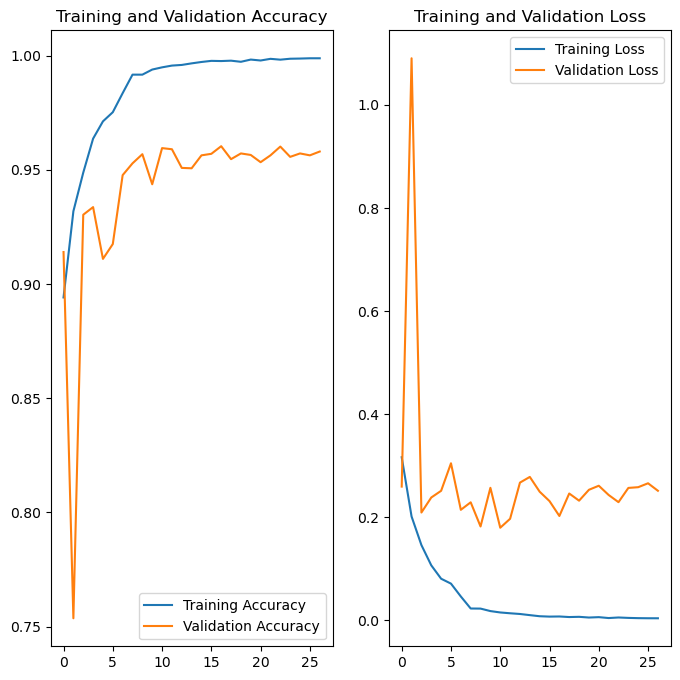

In [5]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [6]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

750/750 [==============================] - 17s 21ms/step
Confusion Matrix
[[957   5   9   6   2  11   0]
 [  8 849   0   1   0   0   0]
 [  1   0 797   4   0  12   0]
 [  0   0   1 688   1   3   0]
 [  0   0   3   0 809  11 106]
 [  0   0  10   4   5 800   0]
 [  0   1   0   2  22  10 861]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.97      0.98       990
      Ae-albopictus       0.99      0.99      0.99       858
          Ae-vexans       0.97      0.98      0.98       814
     An-tessellatus       0.98      0.99      0.98       693
Cx-quinquefasciatus       0.96      0.87      0.92       929
         Cx-vishnui       0.94      0.98      0.96       819
               Misc       0.89      0.96      0.92       896

           accuracy                           0.96      5999
          macro avg       0.96      0.96      0.96      5999
       weighted avg       0.96      0.96      0.96      5999

Model is s

In [7]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-08:29:52

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3087/3087 [==============================] - 282s 91ms/step - loss: 0.1609 - accuracy: 0.9465 - val_loss: 0.1424 - val_accuracy: 0.9592 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3087/3087 [==============================] - 273s 89ms/step - loss: 0.0950 - accuracy: 0.9675 - val_loss: 0.2814 - val_accuracy: 0.9178 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3087/3087 [==============================] - 270s 87ms/step - loss: 0.0612 - accuracy: 0.9799 - val_loss: 0.1754 - val_accuracy: 0.9548 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3087/3087 [==============================] - 276s 90ms/step - loss: 0.0401 - accuracy: 0.9863 - val_loss: 0.2503 - val_accuracy: 0.947

Maximum test accuracy is at 97.62 %.


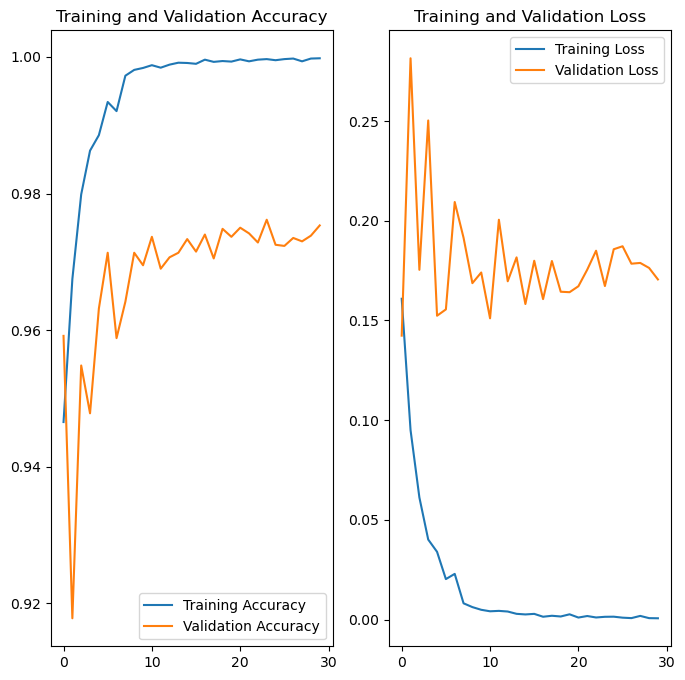

In [8]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [9]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

750/750 [==============================] - 18s 24ms/step
Confusion Matrix
[[973   1  12   0   0   4   0]
 [  0 858   0   0   0   0   0]
 [  0   0 803   1   0  10   0]
 [  0   0   0 692   0   1   0]
 [  0   0   4   0 814   6 105]
 [  0   0   0   0   1 818   0]
 [  0   2   0   0   1   0 893]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       1.00      0.98      0.99       990
      Ae-albopictus       1.00      1.00      1.00       858
          Ae-vexans       0.98      0.99      0.98       814
     An-tessellatus       1.00      1.00      1.00       693
Cx-quinquefasciatus       1.00      0.88      0.93       929
         Cx-vishnui       0.97      1.00      0.99       819
               Misc       0.89      1.00      0.94       896

           accuracy                           0.98      5999
          macro avg       0.98      0.98      0.98      5999
       weighted avg       0.98      0.98      0.98      5999

Model is s

In [10]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-10:44:49

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3087/3087 [==============================] - 310s 100ms/step - loss: 0.2655 - accuracy: 0.9133 - val_loss: 0.2602 - val_accuracy: 0.9308 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3087/3087 [==============================] - 299s 97ms/step - loss: 0.1577 - accuracy: 0.9487 - val_loss: 0.3595 - val_accuracy: 0.9207 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3087/3087 [==============================] - 303s 98ms/step - loss: 0.1102 - accuracy: 0.9619 - val_loss: 0.3035 - val_accuracy: 0.9340 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3087/3087 [==============================] - 299s 97ms/step - loss: 0.0759 - accuracy: 0.9748 - val_loss: 0.4246 - val_accuracy: 0.91

Maximum test accuracy is at 95.18 %.


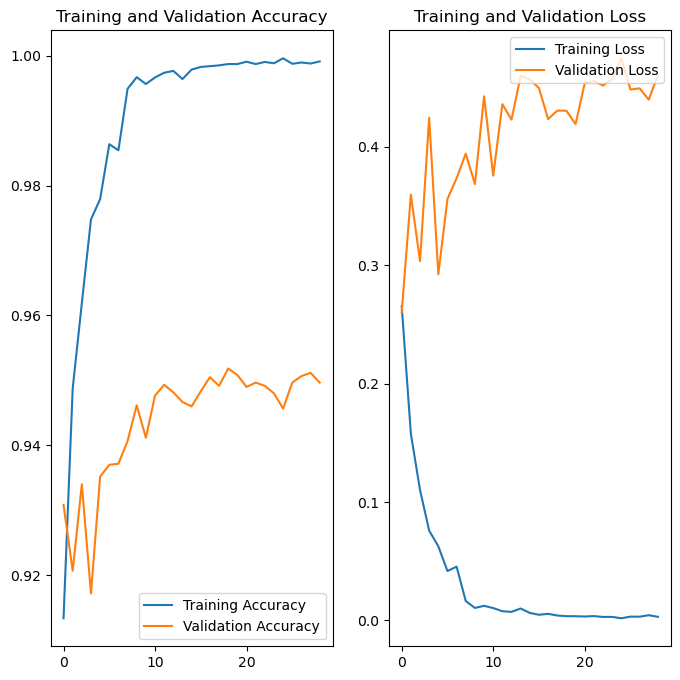

In [11]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [12]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

750/750 [==============================] - 20s 27ms/step
Confusion Matrix
[[975  10   3   1   0   1   0]
 [  2 855   1   0   0   0   0]
 [ 21   0 745   2   4  42   0]
 [  0   0   1 690   1   1   0]
 [  1   1   0   0 754   8 165]
 [  0   0   9   1   1 808   0]
 [  0   1   0   0   9   3 883]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.98      0.98      0.98       990
      Ae-albopictus       0.99      1.00      0.99       858
          Ae-vexans       0.98      0.92      0.95       814
     An-tessellatus       0.99      1.00      0.99       693
Cx-quinquefasciatus       0.98      0.81      0.89       929
         Cx-vishnui       0.94      0.99      0.96       819
               Misc       0.84      0.99      0.91       896

           accuracy                           0.95      5999
          macro avg       0.96      0.95      0.95      5999
       weighted avg       0.96      0.95      0.95      5999

Model is s

In [13]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16460 files belonging to 7 classes.
Found 3998 files belonging to 7 classes.
Found 16460 files belonging to 7 classes.
Found 3998 files belonging to 7 classes.
Found 16460 files belonging to 7 classes.
Found 3998 files belonging to 7 classes.


In [14]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

500/500 [==============================] - 14s 28ms/step


In [15]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
1029/1029 [==============================] - 4s 4ms/step - loss: 0.2259 - accuracy: 0.9518
Epoch 2/20
1029/1029 [==============================] - 5s 4ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 3/20
1029/1029 [==============================] - 5s 5ms/step - loss: 7.2244e-04 - accuracy: 1.0000
Epoch 4/20
1029/1029 [==============================] - 5s 5ms/step - loss: 3.1479e-04 - accuracy: 1.0000
Epoch 5/20
1029/1029 [==============================] - 5s 5ms/step - loss: 1.5723e-04 - accuracy: 1.0000
Epoch 6/20
1029/1029 [==============================] - 5s 5ms/step - loss: 8.3034e-05 - accuracy: 1.0000
Epoch 7/20
1029/1029 [==============================] - 5s 4ms/step - loss: 4.5704e-05 - accuracy: 1.0000
Epoch 8/20
1029/1029 [==============================] - 5s 5ms/step - loss: 2.5624e-05 - accuracy: 1.0000
Epoch 9/20
1029/1029 [==============================] - 5s 5ms/step - loss: 1.4456e-05 - accuracy: 1.0000
Epoch 10/20
1029/1029 [==============================]

125/125 [==============================] - 0s 2ms/step


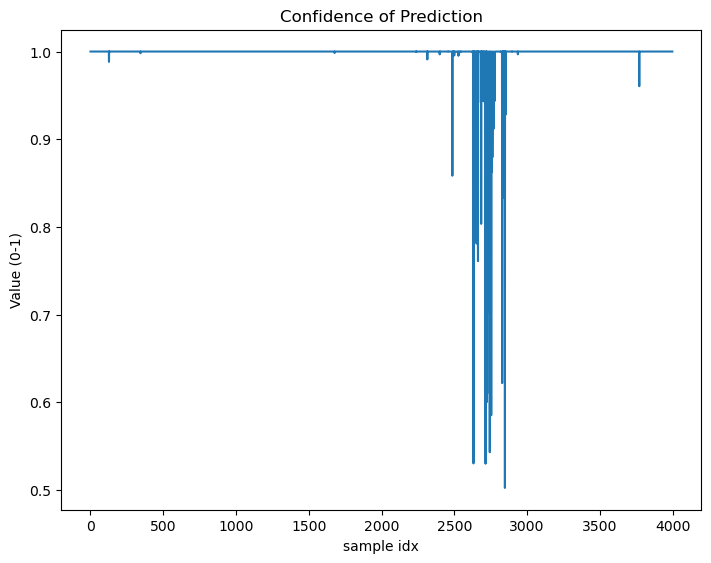

In [16]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [17]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

23706

In [1]:
#---------------MODEL6-----------------------------------------#

In [2]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/All/'
class_names = ['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']

NUM_EPOCH_PER_TRAIN = 30

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 7

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.8, 0.2, 0.0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=10, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))
#--------


def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1                
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            selectedFile = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = RATIO):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

2022-10-17 13:34:49.118374: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmpnraegpgp/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmpnraegpgp/train/Ae-albopictus/ = 7139.
No. of files in "/tmp/tmpnraegpgp/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmpnraegpgp/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmpnraegpgp/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmpnraegpgp/val/Ae-albopictus/ = 1727.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmpnraegpgp/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmpnraegpgp/train/An-tessellatus/ = 5786.
No. of files in "/tmp/tmpnraegpgp/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmpnraegpgp/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmpnraegpgp/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmpnraegpgp/val/An-tessellatus/ = 1419.
Found Ae-aegypti
No. of file

((24705, 5988, 0), (16468, 3991, 0))

In [4]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24705 files belonging to 7 classes.


2022-10-17 13:35:47.075769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 13:35:48.456530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 5988 files belonging to 7 classes.
Found 24705 files belonging to 7 classes.
Found 5988 files belonging to 7 classes.


In [5]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-13:36:13

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-17 13:36:25.802853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1181 of 3089
2022-10-17 13:36:35.799083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2438 of 3089
2022-10-17 13:36:40.288106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-17 13:36:42.209848: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-17 13:36:45.427311: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3089/3089 [==============================] - 280s 80ms/step - loss: 0.3205 - accuracy: 0.8940 - val_loss: 0.5095 - val_accuracy: 0.8218 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 239s 77ms/step - loss: 0.1969 - accuracy: 0.9309 - val_loss: 0.3365 - val_accuracy: 0.8941 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 237s 77ms/step - loss: 0.1417 - accuracy: 0.9511 - val_loss: 0.1887 - val_accuracy: 0.9377 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 234s 76ms/step - loss: 0.1041 - accuracy: 0.9630 - val_loss: 0.1853 - val_accuracy: 0.9415 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3089/3089 [=========

Maximum test accuracy is at 96.66 %.


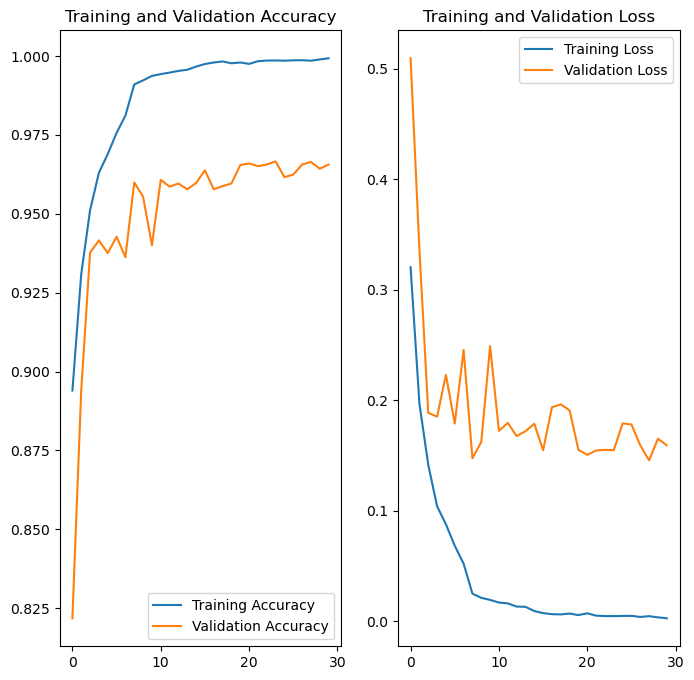

In [6]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [7]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

749/749 [==============================] - 17s 21ms/step
Confusion Matrix
[[953  22  11   0   0   3   1]
 [  7 848   0   3   0   2   3]
 [  3   1 779   2   2   5   0]
 [  0   0   3 705   0   1   0]
 [  6   0   4   0 790  18  95]
 [  0   0   3   1   8 780   0]
 [  0   1   0   0   1   0 927]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.98      0.96      0.97       990
      Ae-albopictus       0.97      0.98      0.98       863
          Ae-vexans       0.97      0.98      0.98       792
     An-tessellatus       0.99      0.99      0.99       709
Cx-quinquefasciatus       0.99      0.87      0.92       913
         Cx-vishnui       0.96      0.98      0.97       792
               Misc       0.90      1.00      0.95       929

           accuracy                           0.97      5988
          macro avg       0.97      0.97      0.97      5988
       weighted avg       0.97      0.97      0.97      5988

Model is s

In [8]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-15:30:58

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3089/3089 [==============================] - 270s 87ms/step - loss: 0.1617 - accuracy: 0.9477 - val_loss: 0.4365 - val_accuracy: 0.8764 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 264s 85ms/step - loss: 0.0919 - accuracy: 0.9675 - val_loss: 0.1293 - val_accuracy: 0.9611 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 266s 86ms/step - loss: 0.0708 - accuracy: 0.9764 - val_loss: 0.1687 - val_accuracy: 0.9524 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 271s 88ms/step - loss: 0.0456 - accuracy: 0.9846 - val_loss: 0.2141 - val_accuracy: 0.942

Maximum test accuracy is at 97.44 %.


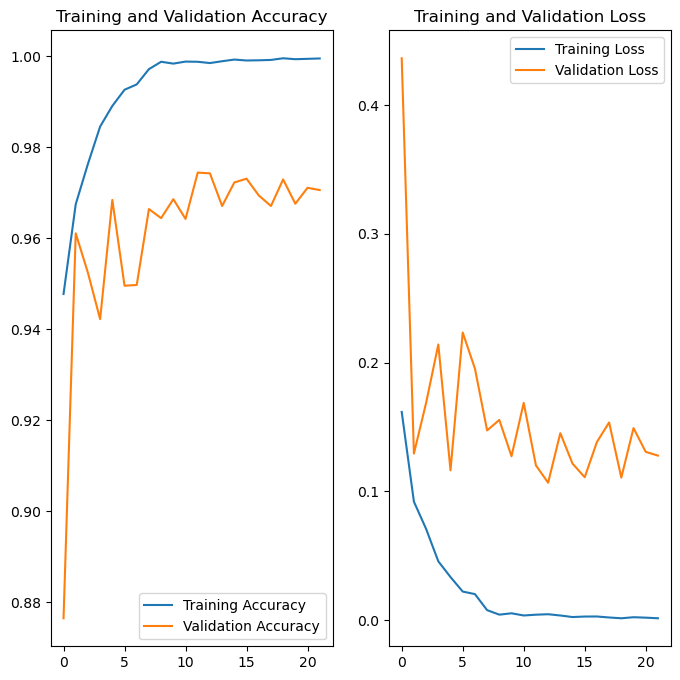

In [9]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [10]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

749/749 [==============================] - 20s 26ms/step
Confusion Matrix
[[974  11   5   0   0   0   0]
 [  8 851   0   2   0   2   0]
 [  0   1 790   1   0   0   0]
 [  0   0   1 708   0   0   0]
 [  0   0   3   0 813  17  80]
 [  0   0   5   0  13 774   0]
 [  0   0   0   0   4   0 925]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.98      0.99       990
      Ae-albopictus       0.99      0.99      0.99       863
          Ae-vexans       0.98      1.00      0.99       792
     An-tessellatus       1.00      1.00      1.00       709
Cx-quinquefasciatus       0.98      0.89      0.93       913
         Cx-vishnui       0.98      0.98      0.98       792
               Misc       0.92      1.00      0.96       929

           accuracy                           0.97      5988
          macro avg       0.98      0.98      0.98      5988
       weighted avg       0.98      0.97      0.97      5988

Model is s

In [11]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-17:09:28

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3089/3089 [==============================] - 307s 99ms/step - loss: 0.2702 - accuracy: 0.9163 - val_loss: 0.3224 - val_accuracy: 0.9001 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 305s 99ms/step - loss: 0.1611 - accuracy: 0.9463 - val_loss: 0.2536 - val_accuracy: 0.9379 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 302s 98ms/step - loss: 0.1114 - accuracy: 0.9633 - val_loss: 0.2631 - val_accuracy: 0.9242 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 303s 98ms/step - loss: 0.0801 - accuracy: 0.9730 - val_loss: 0.3032 - val_accuracy: 0.918

Maximum test accuracy is at 95.27 %.


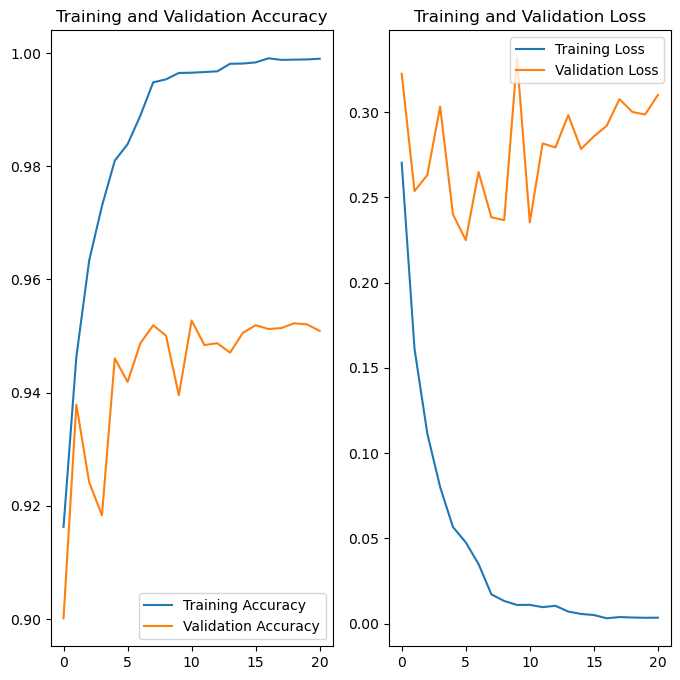

In [12]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [13]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----



749/749 [==============================] - 20s 26ms/step
Confusion Matrix
[[964  12  14   0   0   0   0]
 [  8 854   1   0   0   0   0]
 [ 19  19 746   0   1   7   0]
 [  0   0   1 708   0   0   0]
 [ 19   0   5   0 780   3 106]
 [  0   0   0   0  35 757   0]
 [  0   0   0   0  32   1 896]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.95      0.97      0.96       990
      Ae-albopictus       0.96      0.99      0.98       863
          Ae-vexans       0.97      0.94      0.96       792
     An-tessellatus       1.00      1.00      1.00       709
Cx-quinquefasciatus       0.92      0.85      0.89       913
         Cx-vishnui       0.99      0.96      0.97       792
               Misc       0.89      0.96      0.93       929

           accuracy                           0.95      5988
          macro avg       0.96      0.95      0.95      5988
       weighted avg       0.95      0.95      0.95      5988

Model is s

In [14]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16468 files belonging to 7 classes.
Found 3991 files belonging to 7 classes.
Found 16468 files belonging to 7 classes.
Found 3991 files belonging to 7 classes.
Found 16468 files belonging to 7 classes.
Found 3991 files belonging to 7 classes.


In [15]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

499/499 [==============================] - 14s 28ms/step


In [16]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.2551 - accuracy: 0.9338
Epoch 2/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0022 - accuracy: 0.9999
Epoch 3/20
1030/1030 [==============================] - 5s 5ms/step - loss: 7.7641e-04 - accuracy: 0.9999
Epoch 4/20
1030/1030 [==============================] - 5s 5ms/step - loss: 3.7611e-04 - accuracy: 0.9999
Epoch 5/20
1030/1030 [==============================] - 5s 5ms/step - loss: 2.3083e-04 - accuracy: 0.9999
Epoch 6/20
1030/1030 [==============================] - 5s 5ms/step - loss: 1.1095e-04 - accuracy: 1.0000
Epoch 7/20
1030/1030 [==============================] - 5s 5ms/step - loss: 8.2118e-05 - accuracy: 1.0000
Epoch 8/20
1030/1030 [==============================] - 5s 5ms/step - loss: 4.4148e-05 - accuracy: 1.0000
Epoch 9/20
1030/1030 [==============================] - 5s 5ms/step - loss: 2.3891e-05 - accuracy: 1.0000
Epoch 10/20
1030/1030 [==============================]

125/125 [==============================] - 0s 2ms/step


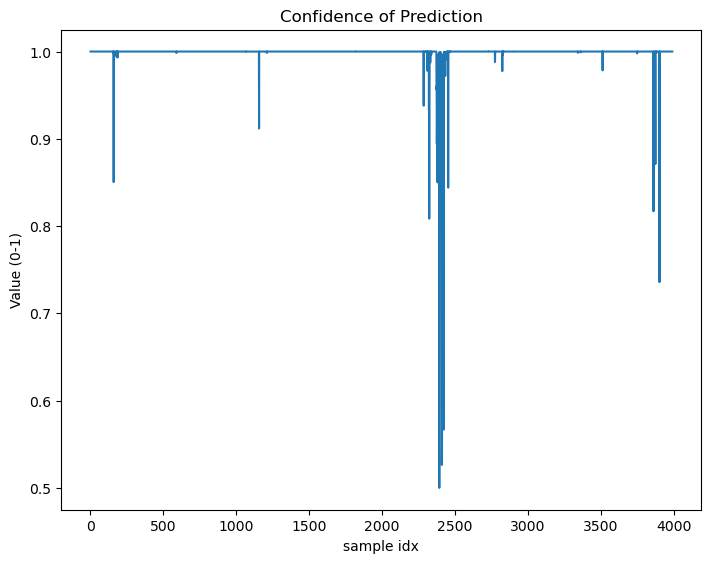

In [17]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [18]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

23697

In [ ]:
#---------------MODEL7-----------------------------------------#

In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/All/'
class_names = ['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']

NUM_EPOCH_PER_TRAIN = 30

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 7

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.8, 0.2, 0.0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=10, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))
#--------


def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1                
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            selectedFile = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = RATIO):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

2022-10-17 20:13:42.102053: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmp8s4f_zmg/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmp8s4f_zmg/train/Ae-albopictus/ = 7128.
No. of files in "/tmp/tmp8s4f_zmg/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmp8s4f_zmg/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmp8s4f_zmg/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmp8s4f_zmg/val/Ae-albopictus/ = 1738.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmp8s4f_zmg/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmp8s4f_zmg/train/An-tessellatus/ = 5797.
No. of files in "/tmp/tmp8s4f_zmg/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmp8s4f_zmg/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmp8s4f_zmg/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmp8s4f_zmg/val/An-tessellatus/ = 1408.
Found Ae-aegypti
No. of file

((24710, 5983, 0), (16472, 3987, 0))

In [3]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24710 files belonging to 7 classes.


2022-10-17 20:14:44.204112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 20:14:45.665838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 5983 files belonging to 7 classes.
Found 24710 files belonging to 7 classes.
Found 5983 files belonging to 7 classes.


In [4]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-20:15:11

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-17 20:15:23.293926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1199 of 3089
2022-10-17 20:15:33.289310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2534 of 3089
2022-10-17 20:15:36.957936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-17 20:15:38.361353: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-17 20:15:41.038154: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3089/3089 [==============================] - 273s 78ms/step - loss: 0.3064 - accuracy: 0.8965 - val_loss: 0.2458 - val_accuracy: 0.9178 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 237s 77ms/step - loss: 0.2125 - accuracy: 0.9268 - val_loss: 0.2499 - val_accuracy: 0.9168 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 236s 76ms/step - loss: 0.1468 - accuracy: 0.9497 - val_loss: 0.3194 - val_accuracy: 0.8994 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 236s 77ms/step - loss: 0.1064 - accuracy: 0.9632 - val_loss: 0.2530 - val_accuracy: 0.9285 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3089/3089 [=========

Maximum test accuracy is at 96.94 %.


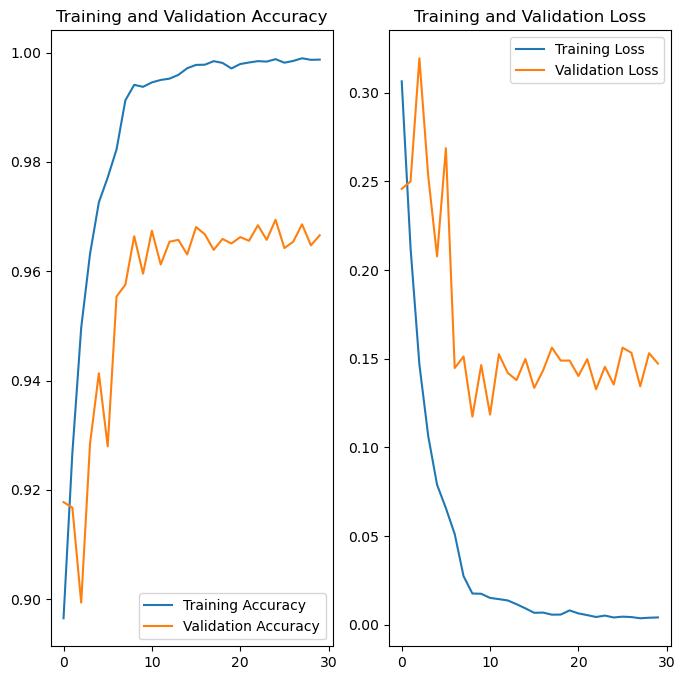

In [5]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [6]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

748/748 [==============================] - 17s 22ms/step
Confusion Matrix
[[987   6   9   1   0   8   1]
 [ 30 829   0   0   1   1   8]
 [  0   0 786   2   0   4   0]
 [  0   0   0 704   0   0   0]
 [  4   0   2   1 828  14  69]
 [  1   0  22   5   2 785   4]
 [  2   1   0   0   2   0 864]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.96      0.98      0.97      1012
      Ae-albopictus       0.99      0.95      0.97       869
          Ae-vexans       0.96      0.99      0.98       792
     An-tessellatus       0.99      1.00      0.99       704
Cx-quinquefasciatus       0.99      0.90      0.95       918
         Cx-vishnui       0.97      0.96      0.96       819
               Misc       0.91      0.99      0.95       869

           accuracy                           0.97      5983
          macro avg       0.97      0.97      0.97      5983
       weighted avg       0.97      0.97      0.97      5983

Model is s

In [7]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/17-22:08:47

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3089/3089 [==============================] - 262s 84ms/step - loss: 0.1626 - accuracy: 0.9479 - val_loss: 0.1107 - val_accuracy: 0.9654 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 266s 86ms/step - loss: 0.0725 - accuracy: 0.9755 - val_loss: 0.1127 - val_accuracy: 0.9702 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 264s 85ms/step - loss: 0.0618 - accuracy: 0.9787 - val_loss: 0.0852 - val_accuracy: 0.9741 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 265s 86ms/step - loss: 0.0408 - accuracy: 0.9865 - val_loss: 0.1003 - val_accuracy: 0.971

Maximum test accuracy is at 98.11 %.


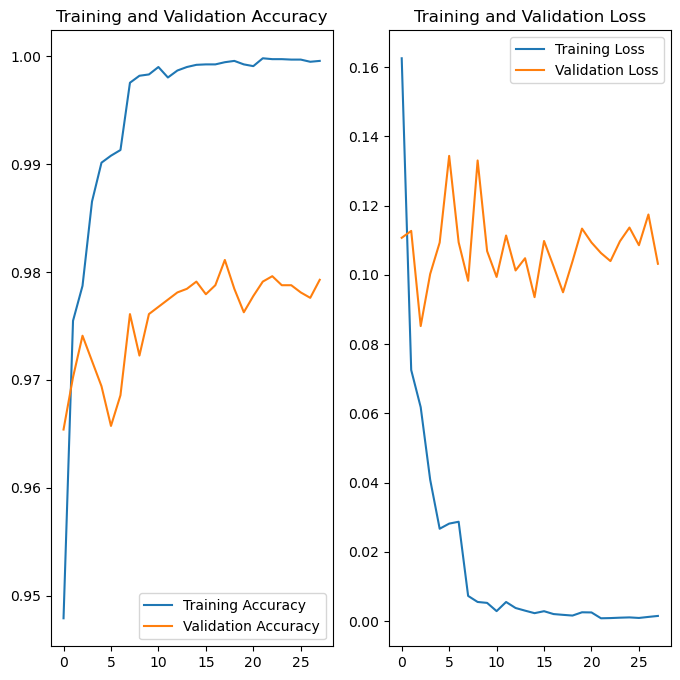

In [8]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [9]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

748/748 [==============================] - 18s 24ms/step
Confusion Matrix
[[1005    6    0    1    0    0    0]
 [  28  837    0    1    0    0    3]
 [   0    0  787    3    0    2    0]
 [   0    0    1  703    0    0    0]
 [   1    0    0    0  865   28   24]
 [   2    0    9    2    2  804    0]
 [   0    0    0    0    0    0  869]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.97      0.99      0.98      1012
      Ae-albopictus       0.99      0.96      0.98       869
          Ae-vexans       0.99      0.99      0.99       792
     An-tessellatus       0.99      1.00      0.99       704
Cx-quinquefasciatus       1.00      0.94      0.97       918
         Cx-vishnui       0.96      0.98      0.97       819
               Misc       0.97      1.00      0.98       869

           accuracy                           0.98      5983
          macro avg       0.98      0.98      0.98      5983
       weighted avg    

In [10]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-00:13:33

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3089/3089 [==============================] - 303s 97ms/step - loss: 0.2713 - accuracy: 0.9136 - val_loss: 0.4420 - val_accuracy: 0.8673 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 298s 96ms/step - loss: 0.1576 - accuracy: 0.9473 - val_loss: 0.2730 - val_accuracy: 0.9316 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 297s 96ms/step - loss: 0.1078 - accuracy: 0.9647 - val_loss: 0.2569 - val_accuracy: 0.9363 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 295s 95ms/step - loss: 0.0814 - accuracy: 0.9714 - val_loss: 0.2951 - val_accuracy: 0.931

Maximum test accuracy is at 95.27 %.


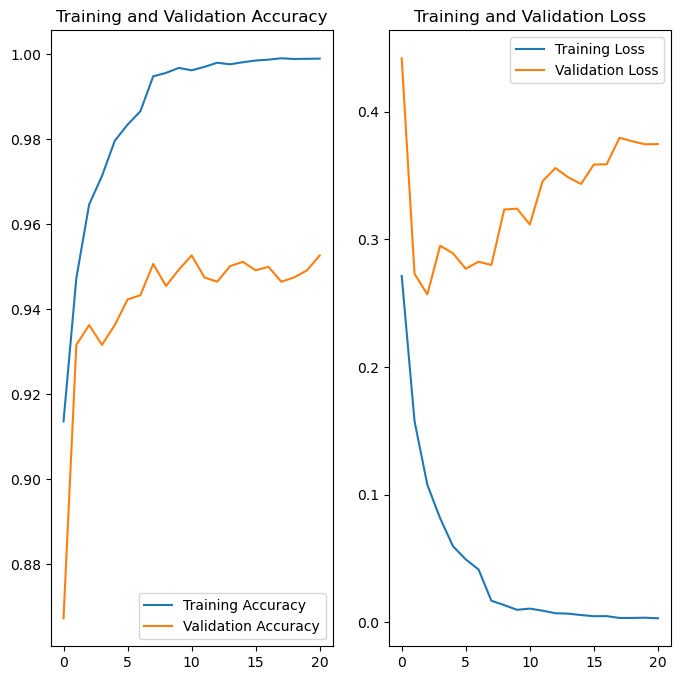

In [11]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [12]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

748/748 [==============================] - 21s 27ms/step
Confusion Matrix
[[949  19  38   5   0   1   0]
 [  7 862   0   0   0   0   0]
 [ 13  10 746   6   2  15   0]
 [  0   0   0 700   2   2   0]
 [  2   0   0   0 797  36  83]
 [  0   0   1  10   0 807   1]
 [  0   0   0   0  28   2 839]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.98      0.94      0.96      1012
      Ae-albopictus       0.97      0.99      0.98       869
          Ae-vexans       0.95      0.94      0.95       792
     An-tessellatus       0.97      0.99      0.98       704
Cx-quinquefasciatus       0.96      0.87      0.91       918
         Cx-vishnui       0.94      0.99      0.96       819
               Misc       0.91      0.97      0.94       869

           accuracy                           0.95      5983
          macro avg       0.95      0.95      0.95      5983
       weighted avg       0.95      0.95      0.95      5983

Model is s

In [13]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16472 files belonging to 7 classes.
Found 3987 files belonging to 7 classes.
Found 16472 files belonging to 7 classes.
Found 3987 files belonging to 7 classes.
Found 16472 files belonging to 7 classes.
Found 3987 files belonging to 7 classes.


In [14]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

499/499 [==============================] - 15s 29ms/step


In [15]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.2938 - accuracy: 0.9387
Epoch 2/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0025 - accuracy: 0.9999
Epoch 3/20
1030/1030 [==============================] - 5s 5ms/step - loss: 7.3710e-04 - accuracy: 1.0000
Epoch 4/20
1030/1030 [==============================] - 5s 4ms/step - loss: 3.2335e-04 - accuracy: 1.0000
Epoch 5/20
1030/1030 [==============================] - 5s 4ms/step - loss: 1.5945e-04 - accuracy: 1.0000
Epoch 6/20
1030/1030 [==============================] - 5s 4ms/step - loss: 8.7183e-05 - accuracy: 1.0000
Epoch 7/20
1030/1030 [==============================] - 5s 4ms/step - loss: 4.9280e-05 - accuracy: 1.0000
Epoch 8/20
1030/1030 [==============================] - 5s 4ms/step - loss: 2.6694e-05 - accuracy: 1.0000
Epoch 9/20
1030/1030 [==============================] - 5s 5ms/step - loss: 1.5529e-05 - accuracy: 1.0000
Epoch 10/20
1030/1030 [==============================]

125/125 [==============================] - 0s 2ms/step


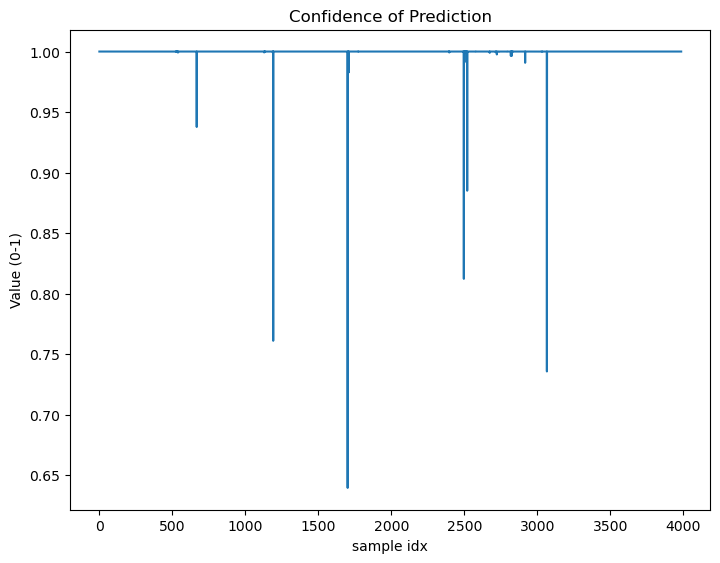

In [16]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [17]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

23851

In [18]:
#---------------MODEL8-----------------------------------------#

In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/All/'
class_names = ['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']

NUM_EPOCH_PER_TRAIN = 30

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 7

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.8, 0.2, 0.0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=10, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))
#--------


def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1                
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            selectedFile = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = RATIO):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

2022-10-18 06:38:36.822361: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmpag7c5uf3/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmpag7c5uf3/train/Ae-albopictus/ = 7095.
No. of files in "/tmp/tmpag7c5uf3/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmpag7c5uf3/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmpag7c5uf3/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmpag7c5uf3/val/Ae-albopictus/ = 1771.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmpag7c5uf3/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmpag7c5uf3/train/An-tessellatus/ = 5797.
No. of files in "/tmp/tmpag7c5uf3/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmpag7c5uf3/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmpag7c5uf3/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmpag7c5uf3/val/An-tessellatus/ = 1408.
Found Ae-aegypti
No. of file

((24687, 6005, 0), (16457, 4002, 0))

In [3]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24687 files belonging to 7 classes.


2022-10-18 06:39:33.340831: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 06:39:34.754768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 6005 files belonging to 7 classes.
Found 24687 files belonging to 7 classes.
Found 6005 files belonging to 7 classes.


In [4]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-06:40:02

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-18 06:40:15.099662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1197 of 3086
2022-10-18 06:40:25.097219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2510 of 3086
2022-10-18 06:40:29.066156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-18 06:40:30.373552: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-18 06:40:32.984443: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3086/3086 [==============================] - 277s 80ms/step - loss: 0.3496 - accuracy: 0.8830 - val_loss: 0.2290 - val_accuracy: 0.9186 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 236s 76ms/step - loss: 0.2054 - accuracy: 0.9286 - val_loss: 0.2683 - val_accuracy: 0.9112 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 236s 77ms/step - loss: 0.1509 - accuracy: 0.9482 - val_loss: 0.1936 - val_accuracy: 0.9344 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 237s 77ms/step - loss: 0.1105 - accuracy: 0.9622 - val_loss: 0.1102 - val_accuracy: 0.9610 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3086/3086 [=========

Maximum test accuracy is at 97.35 %.


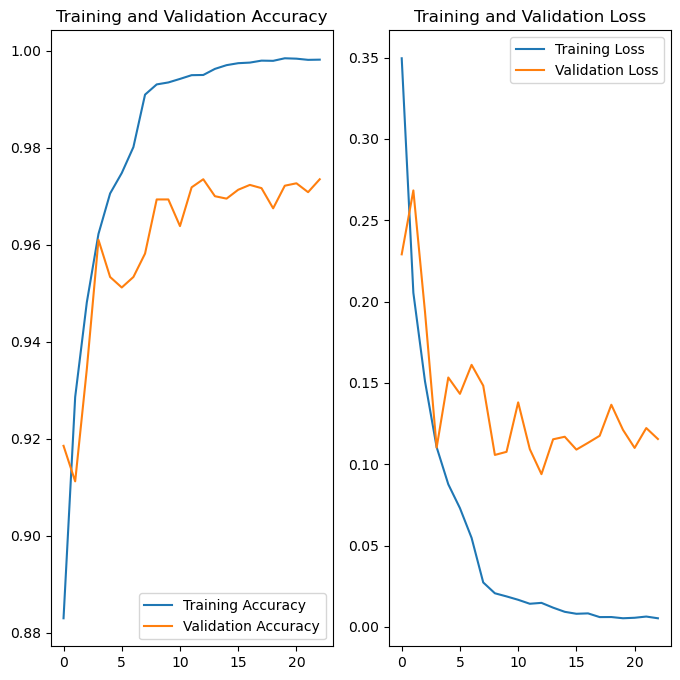

In [5]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [6]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

751/751 [==============================] - 17s 21ms/step
Confusion Matrix
[[965  10   2   1   0   6   0]
 [ 56 828   0   0   0   0   1]
 [  1   0 764   1   3  12   0]
 [  0   0   1 697   0   4   2]
 [  0   0   0   0 905   4  26]
 [  2   0   3   0  12 773   2]
 [  0   0   0   0  10   0 914]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.94      0.98      0.96       984
      Ae-albopictus       0.99      0.94      0.96       885
          Ae-vexans       0.99      0.98      0.99       781
     An-tessellatus       1.00      0.99      0.99       704
Cx-quinquefasciatus       0.97      0.97      0.97       935
         Cx-vishnui       0.97      0.98      0.97       792
               Misc       0.97      0.99      0.98       924

           accuracy                           0.97      6005
          macro avg       0.98      0.97      0.97      6005
       weighted avg       0.97      0.97      0.97      6005

Model is s

In [7]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-08:09:27

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3086/3086 [==============================] - 280s 90ms/step - loss: 0.1723 - accuracy: 0.9443 - val_loss: 0.2336 - val_accuracy: 0.9132 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 270s 88ms/step - loss: 0.0916 - accuracy: 0.9696 - val_loss: 0.0928 - val_accuracy: 0.9695 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 269s 87ms/step - loss: 0.0659 - accuracy: 0.9787 - val_loss: 0.1020 - val_accuracy: 0.9674 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 268s 87ms/step - loss: 0.0402 - accuracy: 0.9869 - val_loss: 0.1189 - val_accuracy: 0.968

Maximum test accuracy is at 98.72 %.


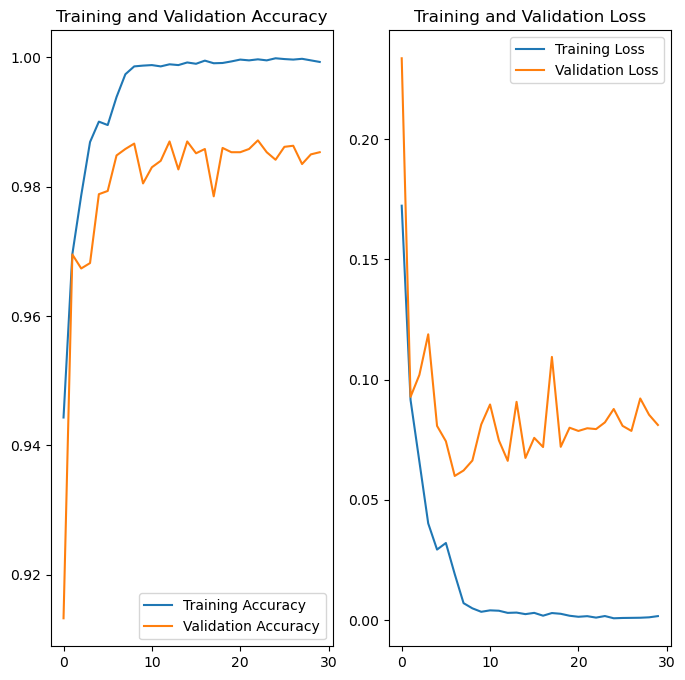

In [8]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [9]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

751/751 [==============================] - 18s 24ms/step
Confusion Matrix
[[983   1   0   0   0   0   0]
 [ 54 831   0   0   0   0   0]
 [  0   0 769   0   1  11   0]
 [  0   0   0 704   0   0   0]
 [  0   0   0   0 927   1   7]
 [  2   0   4   4   2 780   0]
 [  0   0   0   0   1   0 923]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.95      1.00      0.97       984
      Ae-albopictus       1.00      0.94      0.97       885
          Ae-vexans       0.99      0.98      0.99       781
     An-tessellatus       0.99      1.00      1.00       704
Cx-quinquefasciatus       1.00      0.99      0.99       935
         Cx-vishnui       0.98      0.98      0.98       792
               Misc       0.99      1.00      1.00       924

           accuracy                           0.99      6005
          macro avg       0.99      0.99      0.99      6005
       weighted avg       0.99      0.99      0.99      6005

Model is s

In [10]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-10:24:09

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3086/3086 [==============================] - 306s 99ms/step - loss: 0.2894 - accuracy: 0.9063 - val_loss: 0.2073 - val_accuracy: 0.9331 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 309s 100ms/step - loss: 0.1764 - accuracy: 0.9419 - val_loss: 0.1824 - val_accuracy: 0.9429 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 304s 99ms/step - loss: 0.1206 - accuracy: 0.9602 - val_loss: 0.1346 - val_accuracy: 0.9539 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 305s 99ms/step - loss: 0.0958 - accuracy: 0.9667 - val_loss: 0.1506 - val_accuracy: 0.94

Maximum test accuracy is at 96.79 %.


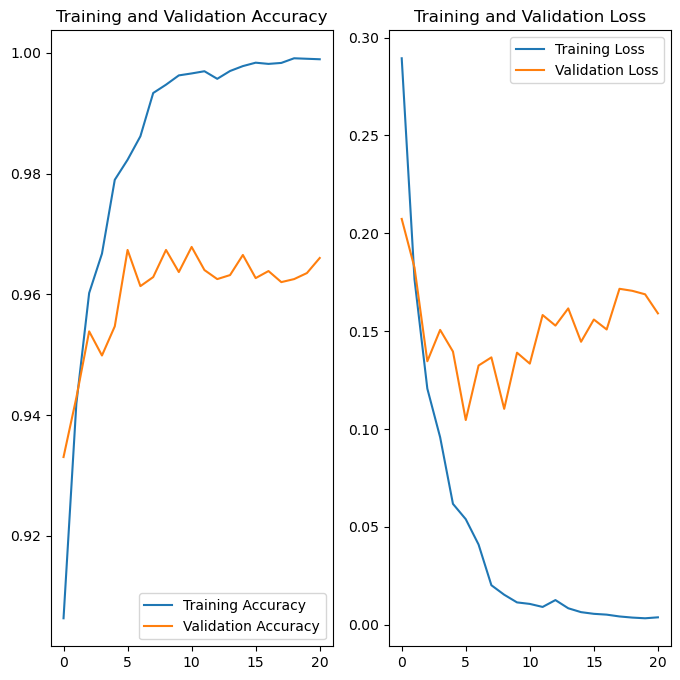

In [11]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [12]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

751/751 [==============================] - 20s 26ms/step
Confusion Matrix
[[974   4   0   4   0   2   0]
 [  1 883   0   0   0   1   0]
 [ 58   1 690   4   3  25   0]
 [  0   0   1 700   0   3   0]
 [  2   0   0   0 879   1  53]
 [  1   0   3   0   5 783   0]
 [  0   1   0   0  18   2 903]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.94      0.99      0.96       984
      Ae-albopictus       0.99      1.00      1.00       885
          Ae-vexans       0.99      0.88      0.94       781
     An-tessellatus       0.99      0.99      0.99       704
Cx-quinquefasciatus       0.97      0.94      0.96       935
         Cx-vishnui       0.96      0.99      0.97       792
               Misc       0.94      0.98      0.96       924

           accuracy                           0.97      6005
          macro avg       0.97      0.97      0.97      6005
       weighted avg       0.97      0.97      0.97      6005

Model is s

In [13]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16457 files belonging to 7 classes.
Found 4002 files belonging to 7 classes.
Found 16457 files belonging to 7 classes.
Found 4002 files belonging to 7 classes.
Found 16457 files belonging to 7 classes.
Found 4002 files belonging to 7 classes.


In [14]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

501/501 [==============================] - 15s 29ms/step


In [15]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
1029/1029 [==============================] - 5s 4ms/step - loss: 0.2220 - accuracy: 0.9658
Epoch 2/20
1029/1029 [==============================] - 5s 5ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 3/20
1029/1029 [==============================] - 5s 5ms/step - loss: 6.2242e-04 - accuracy: 1.0000
Epoch 4/20
1029/1029 [==============================] - 5s 5ms/step - loss: 2.8178e-04 - accuracy: 1.0000
Epoch 5/20
1029/1029 [==============================] - 5s 5ms/step - loss: 1.4911e-04 - accuracy: 1.0000
Epoch 6/20
1029/1029 [==============================] - 5s 4ms/step - loss: 8.2936e-05 - accuracy: 1.0000
Epoch 7/20
1029/1029 [==============================] - 5s 5ms/step - loss: 4.8087e-05 - accuracy: 1.0000
Epoch 8/20
1029/1029 [==============================] - 5s 5ms/step - loss: 2.7915e-05 - accuracy: 1.0000
Epoch 9/20
1029/1029 [==============================] - 5s 4ms/step - loss: 1.6253e-05 - accuracy: 1.0000
Epoch 10/20
1029/1029 [==============================]

126/126 [==============================] - 0s 2ms/step


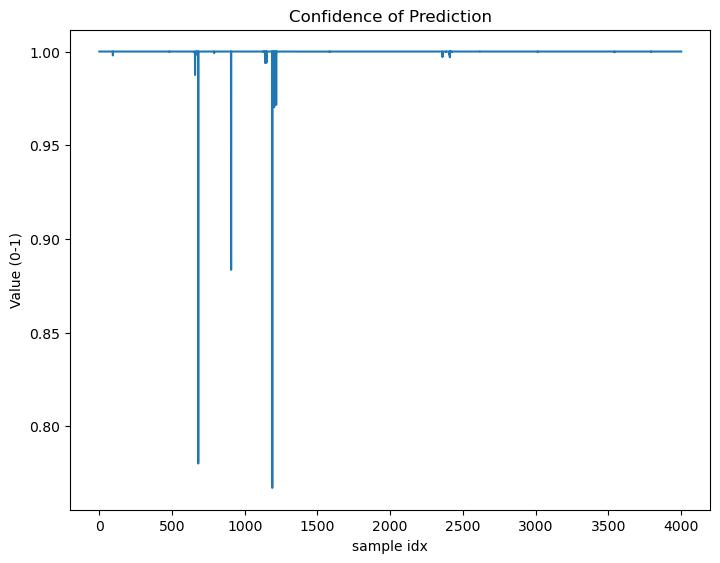

In [16]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [17]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

23700

In [ ]:
#---------------MODEL9-----------------------------------------#

In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/All/'
class_names = ['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']

NUM_EPOCH_PER_TRAIN = 30

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 7

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.8, 0.2, 0.0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=10, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))
#--------


def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1                
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            selectedFile = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = RATIO):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 =  Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

2022-10-18 13:49:08.195577: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmpk235wxy0/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmpk235wxy0/train/Ae-albopictus/ = 7117.
No. of files in "/tmp/tmpk235wxy0/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmpk235wxy0/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmpk235wxy0/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmpk235wxy0/val/Ae-albopictus/ = 1749.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmpk235wxy0/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmpk235wxy0/train/An-tessellatus/ = 5808.
No. of files in "/tmp/tmpk235wxy0/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmpk235wxy0/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmpk235wxy0/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmpk235wxy0/val/An-tessellatus/ = 1397.
Found Ae-aegypti
No. of file

((24683, 6009, 0), (16454, 4005, 0))

In [3]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24683 files belonging to 7 classes.


2022-10-18 13:50:06.566297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 13:50:08.007971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 6009 files belonging to 7 classes.
Found 24683 files belonging to 7 classes.
Found 6009 files belonging to 7 classes.


In [4]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-13:50:34

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-18 13:50:46.244285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1211 of 3086
2022-10-18 13:50:56.259402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2531 of 3086
2022-10-18 13:51:00.098659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-18 13:51:01.422037: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-18 13:51:04.142025: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3086/3086 [==============================] - 275s 79ms/step - loss: 0.3407 - accuracy: 0.8846 - val_loss: 0.1741 - val_accuracy: 0.9393 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 240s 78ms/step - loss: 0.2170 - accuracy: 0.9257 - val_loss: 0.1691 - val_accuracy: 0.9447 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 238s 77ms/step - loss: 0.1529 - accuracy: 0.9462 - val_loss: 0.2203 - val_accuracy: 0.9246 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 240s 78ms/step - loss: 0.1112 - accuracy: 0.9620 - val_loss: 0.1361 - val_accuracy: 0.9541 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3086/3086 [=========

Maximum test accuracy is at 97.44 %.


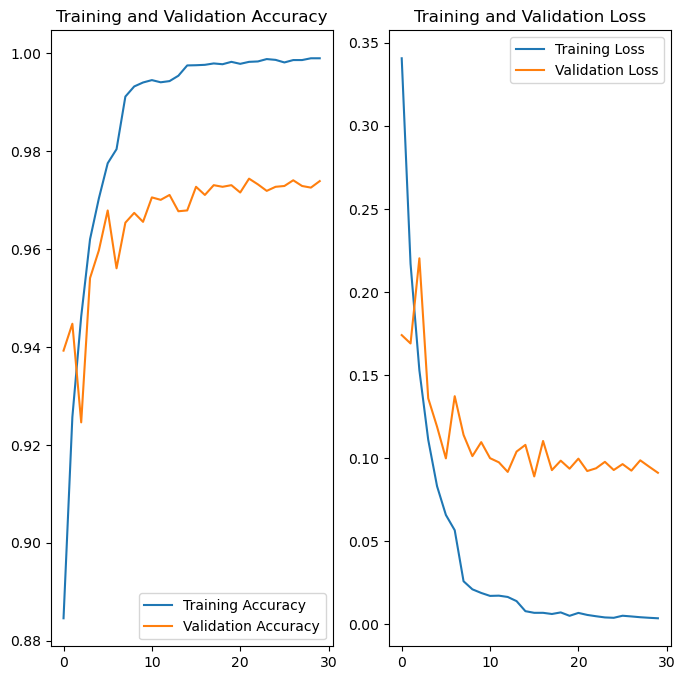

In [5]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [6]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

752/752 [==============================] - 17s 21ms/step
Confusion Matrix
[[996   5   0   0   0   0   0]
 [ 27 845   0   0   0   2   0]
 [  5   0 780   7   1   9   1]
 [  0   0   1 687   0   9   1]
 [  0   0   2   0 873  26  17]
 [  5   0  14   6   5 756   0]
 [  0   1   0   0   5   8 915]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.96      1.00      0.98      1001
      Ae-albopictus       0.99      0.97      0.98       874
          Ae-vexans       0.98      0.97      0.97       803
     An-tessellatus       0.98      0.98      0.98       698
Cx-quinquefasciatus       0.99      0.95      0.97       918
         Cx-vishnui       0.93      0.96      0.95       786
               Misc       0.98      0.98      0.98       929

           accuracy                           0.97      6009
          macro avg       0.97      0.97      0.97      6009
       weighted avg       0.97      0.97      0.97      6009

Model is s

In [7]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-15:44:35

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3086/3086 [==============================] - 261s 84ms/step - loss: 0.1914 - accuracy: 0.9378 - val_loss: 0.1994 - val_accuracy: 0.9308 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 258s 84ms/step - loss: 0.0937 - accuracy: 0.9684 - val_loss: 0.1006 - val_accuracy: 0.9679 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 261s 85ms/step - loss: 0.0671 - accuracy: 0.9778 - val_loss: 0.0735 - val_accuracy: 0.9762 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 259s 84ms/step - loss: 0.0388 - accuracy: 0.9871 - val_loss: 0.0994 - val_accuracy: 0.971

Maximum test accuracy is at 98.77 %.


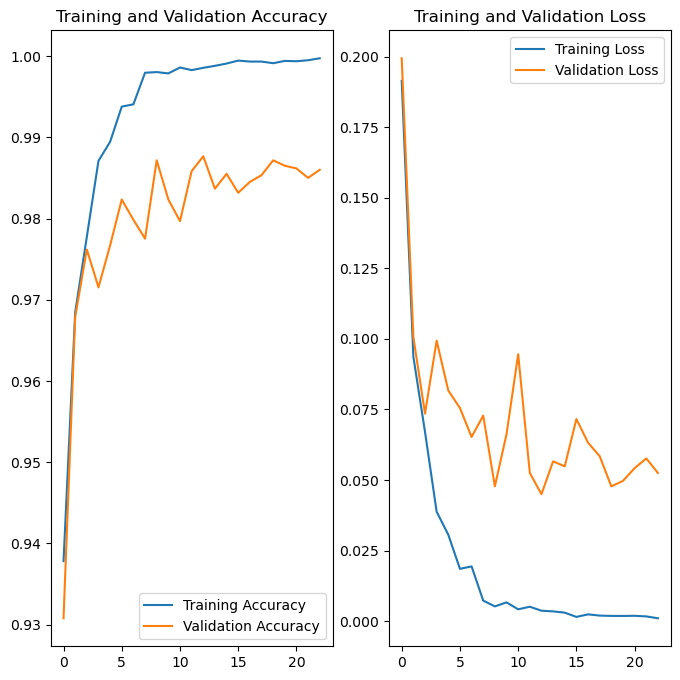

In [8]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [9]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

752/752 [==============================] - 19s 24ms/step
Confusion Matrix
[[993   7   0   0   0   1   0]
 [  5 869   0   0   0   0   0]
 [  1   0 796   5   0   0   1]
 [  0   0   2 694   0   1   1]
 [  0   0   0   0 892  24   2]
 [  0   0  13   0   7 764   2]
 [  0   0   0   0   0   2 927]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.99      0.99      1001
      Ae-albopictus       0.99      0.99      0.99       874
          Ae-vexans       0.98      0.99      0.99       803
     An-tessellatus       0.99      0.99      0.99       698
Cx-quinquefasciatus       0.99      0.97      0.98       918
         Cx-vishnui       0.96      0.97      0.97       786
               Misc       0.99      1.00      1.00       929

           accuracy                           0.99      6009
          macro avg       0.99      0.99      0.99      6009
       weighted avg       0.99      0.99      0.99      6009

Model is s

In [10]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-17:24:32

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3086/3086 [==============================] - 302s 98ms/step - loss: 0.2831 - accuracy: 0.9102 - val_loss: 0.2028 - val_accuracy: 0.9314 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3086/3086 [==============================] - 300s 97ms/step - loss: 0.1801 - accuracy: 0.9413 - val_loss: 0.1736 - val_accuracy: 0.9439 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3086/3086 [==============================] - 308s 100ms/step - loss: 0.1117 - accuracy: 0.9628 - val_loss: 0.1771 - val_accuracy: 0.9481 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3086/3086 [==============================] - 297s 96ms/step - loss: 0.0879 - accuracy: 0.9699 - val_loss: 0.1532 - val_accuracy: 0.94

Maximum test accuracy is at 96.22 %.


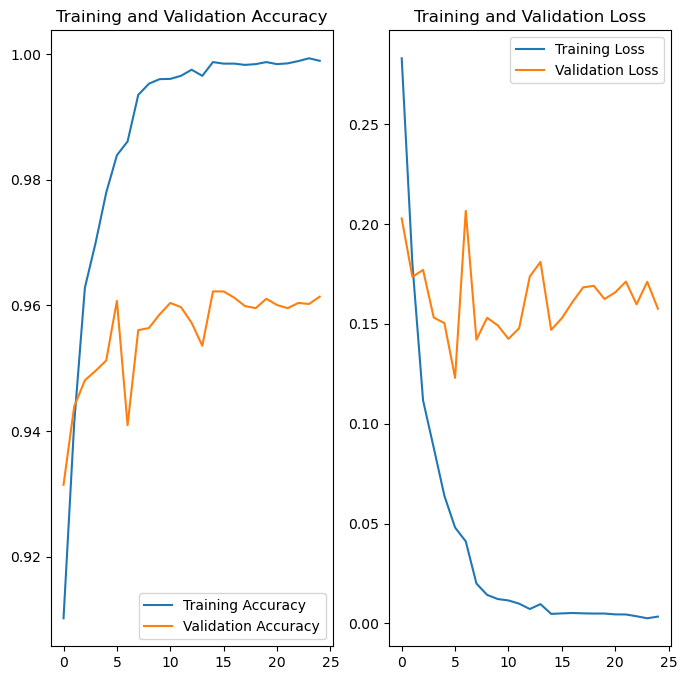

In [11]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [12]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

752/752 [==============================] - 21s 28ms/step
Confusion Matrix
[[993   8   0   0   0   0   0]
 [ 13 861   0   0   0   0   0]
 [ 29  32 718   1   0  23   0]
 [  0   0   0 698   0   0   0]
 [  1   0   0   0 889   1  27]
 [  0   1  13   1  25 740   6]
 [  0   3   0   0  39   4 883]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.96      0.99      0.97      1001
      Ae-albopictus       0.95      0.99      0.97       874
          Ae-vexans       0.98      0.89      0.94       803
     An-tessellatus       1.00      1.00      1.00       698
Cx-quinquefasciatus       0.93      0.97      0.95       918
         Cx-vishnui       0.96      0.94      0.95       786
               Misc       0.96      0.95      0.96       929

           accuracy                           0.96      6009
          macro avg       0.96      0.96      0.96      6009
       weighted avg       0.96      0.96      0.96      6009

Model is s

In [13]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16454 files belonging to 7 classes.
Found 4005 files belonging to 7 classes.
Found 16454 files belonging to 7 classes.
Found 4005 files belonging to 7 classes.
Found 16454 files belonging to 7 classes.
Found 4005 files belonging to 7 classes.


In [14]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

501/501 [==============================] - 14s 28ms/step


In [15]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
1029/1029 [==============================] - 5s 4ms/step - loss: 0.2503 - accuracy: 0.9353
Epoch 2/20
1029/1029 [==============================] - 5s 5ms/step - loss: 0.0023 - accuracy: 0.9999
Epoch 3/20
1029/1029 [==============================] - 5s 5ms/step - loss: 7.8019e-04 - accuracy: 0.9999
Epoch 4/20
1029/1029 [==============================] - 5s 5ms/step - loss: 3.9472e-04 - accuracy: 0.9999
Epoch 5/20
1029/1029 [==============================] - 5s 5ms/step - loss: 2.2288e-04 - accuracy: 1.0000
Epoch 6/20
1029/1029 [==============================] - 5s 5ms/step - loss: 1.3469e-04 - accuracy: 1.0000
Epoch 7/20
1029/1029 [==============================] - 5s 5ms/step - loss: 6.8531e-05 - accuracy: 1.0000
Epoch 8/20
1029/1029 [==============================] - 4s 4ms/step - loss: 4.6590e-05 - accuracy: 1.0000
Epoch 9/20
1029/1029 [==============================] - 5s 5ms/step - loss: 3.0150e-05 - accuracy: 1.0000
Epoch 10/20
1029/1029 [==============================]

126/126 [==============================] - 0s 2ms/step


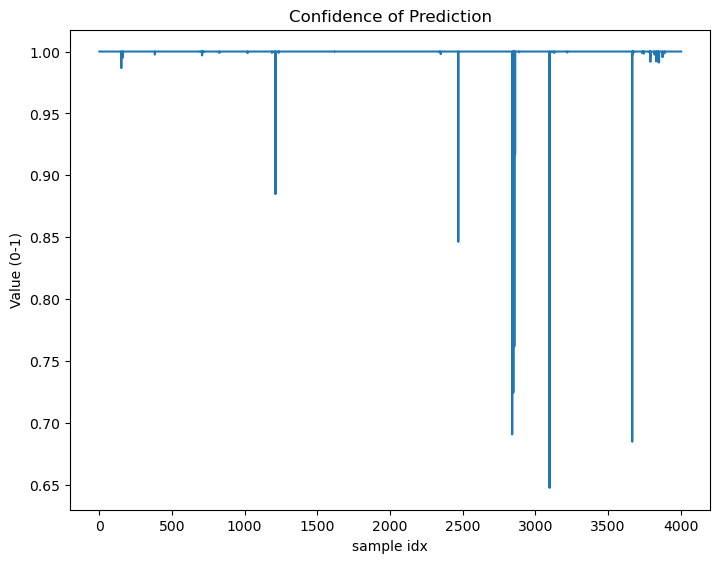

In [16]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [17]:
import sys
this = sys.modules[__name__]
for n in dir():
    if 'train_ds' in n: 
        delattr(this, n)
    if 'val_ds' in n: 
        delattr(this, n)
    if 'Y_' in n: 
        delattr(this, n)
    if 'Yh_' in n: 
        delattr(this, n)
del model
tf.keras.backend.clear_session()
gc.collect()

23851

In [ ]:
#---------------MODEL 10-----------------------------------------#

In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/Chula7MosDatasets/All/'
class_names = ['Ae-aegypti', 'Ae-albopictus', 'Ae-vexans', 'An-tessellatus', 'Cx-quinquefasciatus', 'Cx-vishnui', 'Misc']

NUM_EPOCH_PER_TRAIN = 30

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 7

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.8, 0.2, 0.0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=10, restore_best_weights = True)
run_no = 0
model_no = 0
acc = np.zeros((4,10))
#--------


def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1                
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                #print(selectedFile)
                no = selectedFile.find('_s')
                no+=2
                while selectedFile[no:no+1].isnumeric():
                    no+=1
                selectedFile = selectedFile[:no] + '*'
                #print('Selected ' + selectedFile)
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            selectedFile = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ selectedFile, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = RATIO):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(7, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    fitHistory = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    global acc, model_no, run_no
    acc[model_no, run_no] = np.max(fitHistory.history['val_accuracy'])
    model_no += 1
    return fitHistory


def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

2022-10-18 21:55:27.102947: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# recall the models that haven't seen the new dataset
earlyModelPathR = './models/Model_Early_Combine_Park_2022-09-20_00-17.h5'
middleModelPathR = './models/Model_Middle_Combine_Park_2022-09-20_02-33.h5'
lateModelPathR = './models/Model_Late_Combine_Park_2022-09-20_04-37.h5'

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Ae-albopictus
No. of files in Ae-albopictus = 8866.
No. of files in "/tmp/tmpxcp87qla/train/Ae-albopictus/" should be around 7093.
No. of files in /tmp/tmpxcp87qla/train/Ae-albopictus/ = 7117.
No. of files in "/tmp/tmpxcp87qla/test/Ae-albopictus/" should be around 0.
No. of files in /tmp/tmpxcp87qla/test/Ae-albopictus/ = 0.
No. of files in "/tmp/tmpxcp87qla/val/Ae-albopictus/" should be around 1774.
No. of files in /tmp/tmpxcp87qla/val/Ae-albopictus/ = 1749.
Found An-tessellatus
No. of files in An-tessellatus = 7205.
No. of files in "/tmp/tmpxcp87qla/train/An-tessellatus/" should be around 5764.
No. of files in /tmp/tmpxcp87qla/train/An-tessellatus/ = 5797.
No. of files in "/tmp/tmpxcp87qla/test/An-tessellatus/" should be around 0.
No. of files in /tmp/tmpxcp87qla/test/An-tessellatus/ = 0.
No. of files in "/tmp/tmpxcp87qla/val/An-tessellatus/" should be around 1441.
No. of files in /tmp/tmpxcp87qla/val/An-tessellatus/ = 1408.
Found Ae-aegypti
No. of file

((24709, 5982, 0), (16472, 3987, 0))

In [3]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 24709 files belonging to 7 classes.


2022-10-18 21:56:24.971189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 21:56:26.335200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 5982 files belonging to 7 classes.
Found 24709 files belonging to 7 classes.
Found 5982 files belonging to 7 classes.


In [4]:
model = keras.models.load_model(earlyModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-21:56:52

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30


2022-10-18 21:57:03.974661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1215 of 3089
2022-10-18 21:57:13.969815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2510 of 3089
2022-10-18 21:57:17.996714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-10-18 21:57:19.277183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-10-18 21:57:21.945140: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3089/3089 [==============================] - 273s 78ms/step - loss: 0.3262 - accuracy: 0.8911 - val_loss: 0.4254 - val_accuracy: 0.8529 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 236s 76ms/step - loss: 0.1956 - accuracy: 0.9310 - val_loss: 0.1655 - val_accuracy: 0.9407 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 236s 76ms/step - loss: 0.1401 - accuracy: 0.9532 - val_loss: 0.1896 - val_accuracy: 0.9361 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 238s 77ms/step - loss: 0.1053 - accuracy: 0.9640 - val_loss: 0.1945 - val_accuracy: 0.9365 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/30
3089/3089 [=========

Maximum test accuracy is at 97.38 %.


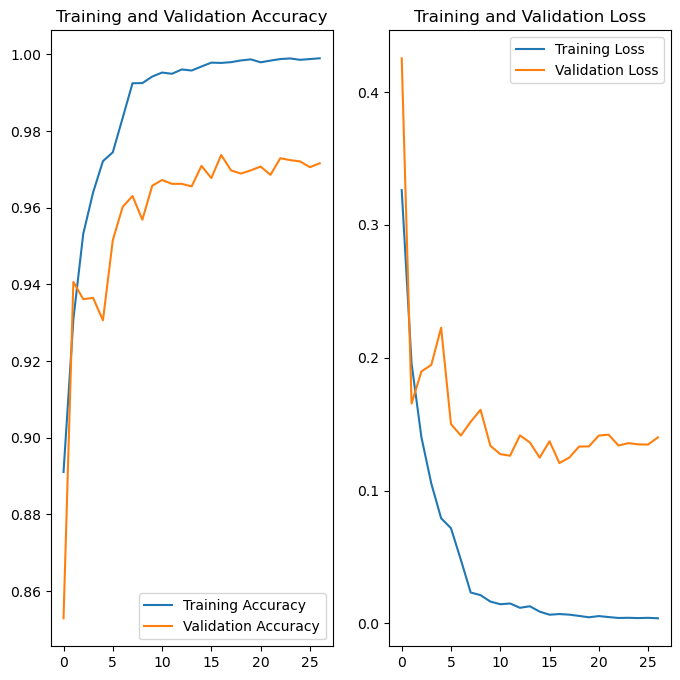

In [5]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [6]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

748/748 [==============================] - 17s 21ms/step
Confusion Matrix
[[956   7   5   0   0   0   0]
 [ 20 853   0   0   0   1   0]
 [  4   0 786   1   2  15   0]
 [  0   0   0 702   0   2   0]
 [  0   0   3   2 841  46  26]
 [  2   1   2   6   0 803   0]
 [  0   0   1   0  11   0 884]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.97      0.99      0.98       968
      Ae-albopictus       0.99      0.98      0.98       874
          Ae-vexans       0.99      0.97      0.98       808
     An-tessellatus       0.99      1.00      0.99       704
Cx-quinquefasciatus       0.98      0.92      0.95       918
         Cx-vishnui       0.93      0.99      0.96       814
               Misc       0.97      0.99      0.98       896

           accuracy                           0.97      5982
          macro avg       0.97      0.97      0.97      5982
       weighted avg       0.97      0.97      0.97      5982

Model is s

In [7]:
model = keras.models.load_model(middleModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/18-23:39:58

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3089/3089 [==============================] - 267s 86ms/step - loss: 0.1723 - accuracy: 0.9444 - val_loss: 0.2384 - val_accuracy: 0.9246 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 270s 87ms/step - loss: 0.0977 - accuracy: 0.9673 - val_loss: 0.1156 - val_accuracy: 0.9692 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 268s 87ms/step - loss: 0.0567 - accuracy: 0.9813 - val_loss: 0.5627 - val_accuracy: 0.8694 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 263s 85ms/step - loss: 0.0485 - accuracy: 0.9841 - val_loss: 0.0864 - val_accuracy: 0.973

Maximum test accuracy is at 98.55 %.


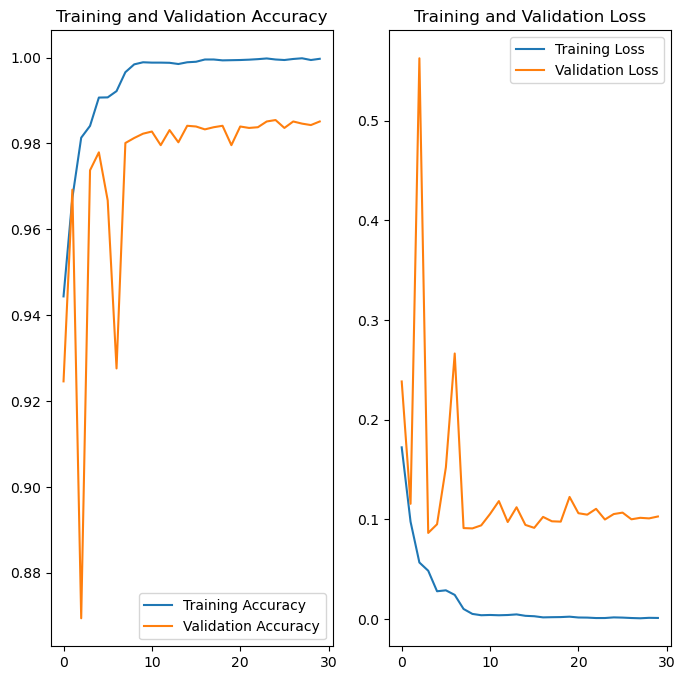

In [8]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [9]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

748/748 [==============================] - 18s 24ms/step
Confusion Matrix
[[962   1   4   1   0   0   0]
 [  9 865   0   0   0   0   0]
 [  1   0 802   0   0   5   0]
 [  0   0   0 704   0   0   0]
 [  0   0   0   0 871  36  11]
 [  4   4   3   0   0 794   9]
 [  0   0   0   0   0   1 895]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.99      0.99      0.99       968
      Ae-albopictus       0.99      0.99      0.99       874
          Ae-vexans       0.99      0.99      0.99       808
     An-tessellatus       1.00      1.00      1.00       704
Cx-quinquefasciatus       1.00      0.95      0.97       918
         Cx-vishnui       0.95      0.98      0.96       814
               Misc       0.98      1.00      0.99       896

           accuracy                           0.99      5982
          macro avg       0.99      0.99      0.99      5982
       weighted avg       0.99      0.99      0.99      5982

Model is s

In [10]:
model = keras.models.load_model(lateModelPathR)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/10/19-01:52:35

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/30
3089/3089 [==============================] - 313s 101ms/step - loss: 0.2833 - accuracy: 0.9081 - val_loss: 0.1572 - val_accuracy: 0.9467 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/30
3089/3089 [==============================] - 303s 98ms/step - loss: 0.1688 - accuracy: 0.9417 - val_loss: 0.1388 - val_accuracy: 0.9557 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/30
3089/3089 [==============================] - 303s 98ms/step - loss: 0.1248 - accuracy: 0.9587 - val_loss: 0.1373 - val_accuracy: 0.9552 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/30
3089/3089 [==============================] - 301s 98ms/step - loss: 0.0826 - accuracy: 0.9721 - val_loss: 0.1247 - val_accuracy: 0.96

Maximum test accuracy is at 97.17 %.


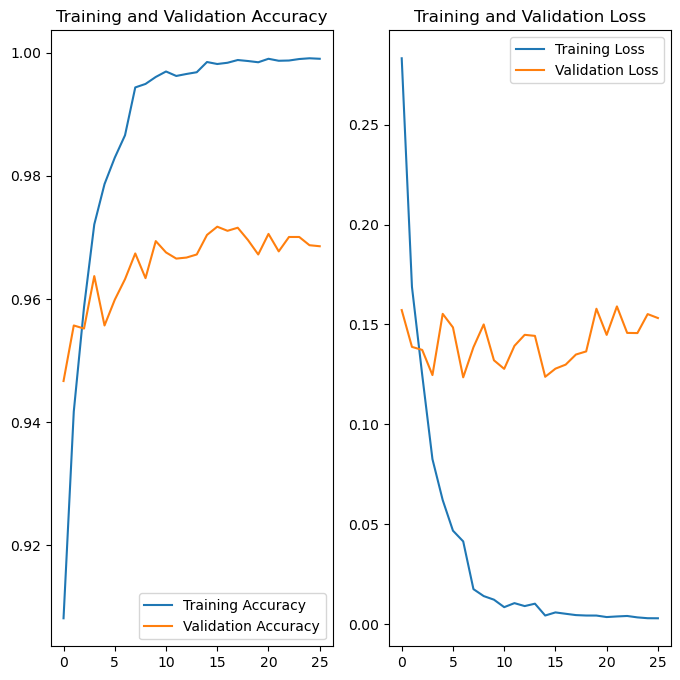

In [11]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [12]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

748/748 [==============================] - 21s 27ms/step
Confusion Matrix
[[918  21  29   0   0   0   0]
 [ 13 854   3   4   0   0   0]
 [  1   0 804   0   0   3   0]
 [  0   0   0 703   0   1   0]
 [  5   0   5   0 857  37  14]
 [  1   0  16   2   7 788   0]
 [  1   0   0   0   5   1 889]]


Classification Report
                     precision    recall  f1-score   support

         Ae-aegypti       0.98      0.95      0.96       968
      Ae-albopictus       0.98      0.98      0.98       874
          Ae-vexans       0.94      1.00      0.97       808
     An-tessellatus       0.99      1.00      1.00       704
Cx-quinquefasciatus       0.99      0.93      0.96       918
         Cx-vishnui       0.95      0.97      0.96       814
               Misc       0.98      0.99      0.99       896

           accuracy                           0.97      5982
          macro avg       0.97      0.97      0.97      5982
       weighted avg       0.97      0.97      0.97      5982

Model is s

In [13]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 16472 files belonging to 7 classes.
Found 3987 files belonging to 7 classes.
Found 16472 files belonging to 7 classes.
Found 3987 files belonging to 7 classes.
Found 16472 files belonging to 7 classes.
Found 3987 files belonging to 7 classes.


In [14]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

499/499 [==============================] - 14s 28ms/step


In [15]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
1030/1030 [==============================] - 5s 4ms/step - loss: 0.4398 - accuracy: 0.8294
Epoch 2/20
1030/1030 [==============================] - 5s 5ms/step - loss: 0.0146 - accuracy: 0.9999
Epoch 3/20
1030/1030 [==============================] - 5s 4ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 4/20
1030/1030 [==============================] - 5s 4ms/step - loss: 4.3713e-04 - accuracy: 1.0000
Epoch 5/20
1030/1030 [==============================] - 5s 5ms/step - loss: 2.1688e-04 - accuracy: 1.0000
Epoch 6/20
1030/1030 [==============================] - 5s 4ms/step - loss: 1.1465e-04 - accuracy: 1.0000
Epoch 7/20
1030/1030 [==============================] - 5s 4ms/step - loss: 6.5711e-05 - accuracy: 1.0000
Epoch 8/20
1030/1030 [==============================] - 5s 4ms/step - loss: 3.6717e-05 - accuracy: 1.0000
Epoch 9/20
1030/1030 [==============================] - 5s 4ms/step - loss: 2.0737e-05 - accuracy: 1.0000
Epoch 10/20
1030/1030 [==============================] - 5

125/125 [==============================] - 0s 2ms/step


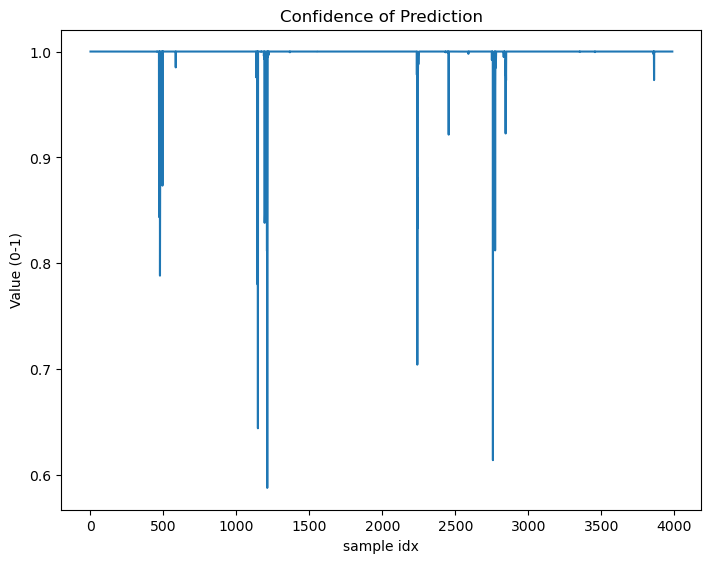

In [16]:
loss, acc[model_no, run_no] = ensemble.evaluate(Yh_val,Y_val)
model_no = 0
run_no += 1
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)
#----------------------------------


In [ ]:
#---------------MODEL 11-----------------------------------------#

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [ ]:
#---------------MODEL 11-----------------------------------------#

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)